<a href="https://colab.research.google.com/github/andrealamanna/cnn_prediction_abnormalities_mammography/blob/main/Scratch_CNN_BenMal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Task 2**
## CNN for ben/mal classifications

#Perliminar phases

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns # Grouped bar plot
import itertools
import numpy as np
import pandas as pd 
#import ast #Abstract Syntax Trees
import os 
import gc # Garbage Collector
from skimage import data, img_as_float
from skimage import exposure

from tensorflow import keras
from tensorflow.keras import backend as K # Useful to free GPU and memory
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import optimizers
from keras import layers, models, regularizers, metrics
from keras.models import load_model
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import auc
from sklearn.utils import class_weight

print("Done")

Done


In [ ]:
BATCH_SIZE = 32
EPOCHS = 100
IMAGE_HEIGHT = 150
IMAGE_WIDTH = 150
#PAT = 4

METRICS = [
      metrics.BinaryAccuracy(name='acc'),
      metrics.Precision(name='prec'),
      metrics.Recall(name='rec'),
      metrics.AUC(name='auc')
]

base_path = "/content/gdrive/My Drive/Colab Notebooks/DLProject/Lamanna/"

MODEL_PATH = os.path.join(base_path, "models/Scratch")
PLOTS_PATH = os.path.join(base_path, "plots/Scratch")
RESULT_PATH = os.path.join(base_path, "results/Ben_Mal/Scratch7BenMal")

train_img_path = os.path.join(base_path, "numpy data/train_tensor.npy")
train_label_path = os.path.join(base_path, "numpy data/train_labels.npy")
test_img_path = os.path.join(base_path, "numpy data/public_test_tensor.npy")
test_label_path = os.path.join(base_path, "numpy data/public_test_labels.npy")

#file_path_out = os.path.join(RESULT_PATH, "top3_results.csv")
#file_path = os.path.join(RESULT_PATH, "results-CM.csv")
#model_path = os.path.join(MODEL_PATH, "best_model.h5")

print("Done")

Done


# Utility Functions

In [ ]:
# Remove baseline samples
def remove_baseline(samples): 
  max_index = int(len(samples)/2)
  indexes = [2*i + 1 for i in range(0, max_index)]

  return samples[indexes]

# Interchange the dataset index
def shuffle_dataset(i, j):
  indexes = tf.range(start=0, limit=tf.shape(i)[0], dtype=tf.int32)
  shuffled_indexes = tf.random.shuffle(indexes)

  i = tf.gather(i, shuffled_indexes)
  j = tf.gather(j, shuffled_indexes)

  i = i.numpy()
  j = j.numpy()

  return i, j

# Unify masses and calcifications 
def labels_mapping(labels):
  labels_local = np.zeros(shape=labels.shape, dtype="float32")
  idx = 0
  for label in labels:
    # Benign
    if label == 1 or label == 3:
      labels_local[idx] = 0
    # Malignant
    else:
      labels_local[idx] = 1
    idx += 1

  return labels_local

print("Done")

#removing benign calcification for balancing
def remove_ben(samples, labels):
  unique, counts = np.unique(labels, return_counts=True)
  min_elems = np.min(counts)
  local_samples=np.zeros((min_elems*2,) + samples[0].shape)
  local_labels=np.zeros((min_elems*2,))
  
  count_ben = 0
  i = 0
  #for i in range(len(samples)):
  for sample, label in list(zip(samples,labels)):
    if (label == 0 and count_ben < min_elems):
      local_labels[i] = label
      local_samples[i] = sample
      count_ben += 1
      i += 1
    elif label == 1:
      local_labels[i] = label
      local_samples[i] = sample
      i += 1

  return local_samples, local_labels

Done


In [ ]:
#test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_datagen.flow(test_images,
def test_model(model):
  test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_datagen.flow(test_images,
                                            test_labels,
                                            batch_size=BATCH_SIZE,
                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE)#,
                                      #callbacks=[GarbageCollectorCallback()])
  print("\n---------------------------------")
  print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
  print("Loss:", "%0.2f" % (test_loss), "%")
  print("Precision:", "%0.2f" % (test_precision*100), "%")
  print("Recall:", "%0.2f" % (test_recall*100), "%")
  print("AUC:", "%0.2f" % test_auc)
  print("---------------------------------\n")
  
print("Done")

Done


In [ ]:
def print_opt_results(history_0):
  # History of accuracy and loss
  tr_loss_0 = history_0.history['loss']
  tr_acc_0 = history_0.history['acc']
  tr_prec_0 = history_0.history['prec']
  tr_rec_0 = history_0.history['rec']
  val_loss_0 = history_0.history['val_loss']
  val_acc_0 = history_0.history['val_acc']
  val_prec_0 = history_0.history['val_prec']
  val_rec_0 = history_0.history['val_rec']

  # Total number of epochs training
  epochs_0 = range(1, len(tr_acc_0)+1)
  end_epoch_0 = len(tr_acc_0)

  # Epoch when reached the val acc max
  opt_epoch_0 = val_acc_0.index(max(val_acc_0)) + 1

  # Loss and accuracy on the validation set
  end_val_loss_0 = val_loss_0[len(val_loss_0)-1]
  end_val_acc_0 = val_acc_0[len(val_acc_0)-1]
  end_val_prec_0 = val_loss_0[len(val_prec_0)-1]
  end_val_rec_0 = val_acc_0[len(val_rec_0)-1]
  opt_val_loss_0 = val_loss_0[opt_epoch_0-1]
  opt_val_acc_0 = val_acc_0[opt_epoch_0-1]
  opt_val_prec_0 = val_prec_0[opt_epoch_0-1]
  opt_val_rec_0 = val_rec_0[opt_epoch_0-1]

  print("Epoch [end]: %d" % end_epoch_0)
  print("Epoch [opt]: %d" % opt_epoch_0)
  print("Valid accuracy [end]: %.4f" % end_val_acc_0)
  print("Valid accuracy [opt]: %.4f" % opt_val_acc_0)
  print("Valid loss [end]: %.4f" % end_val_loss_0)
  print("Valid loss [opt]: %.4f" % opt_val_loss_0)
  print("Valid precision [end]: %.4f" % end_val_prec_0)
  print("Valid precision [opt]: %.4f" % opt_val_prec_0)
  print("Valid recall [end]: %.4f" % end_val_rec_0)
  print("Valid recall [opt]: %.4f" % opt_val_rec_0)

print("Done")

Done


In [ ]:
def plot_acc(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  epochs = range(len(acc))
  plt.figure()
  plt.plot(epochs, acc, 'b', linestyle='dashed', label='Training accuracy',color='Green')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy',color='Blue')
  plt.title('Training and validation accuracy')
  plt.legend()
  return plt

def plot_loss(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))
  plt.figure()
  plt.plot(epochs, loss, 'b', linestyle='dashed', label='Training loss',color='cyan')
  plt.plot(epochs, val_loss, 'b', label='Validation loss',color='orange')
  plt.title('Training and validation loss')
  plt.legend()
  return plt

def plot_prec(history):
  prec = history.history['prec']
  val_prec = history.history['val_prec']
  epochs = range(len(prec))
  plt.figure()
  plt.plot(epochs, prec, 'b', linestyle='dashed', label='Training prec',color='red')
  plt.plot(epochs, val_prec, 'b', label='Validation prec',color='royalblue')
  plt.title('Training and validation prec')
  plt.legend()
  return plt

def plot_rec(history):
  rec = history.history['rec']
  val_rec = history.history['val_rec']
  epochs = range(len(rec))
  plt.figure()
  plt.plot(epochs, rec, 'b', linestyle='dashed', label='Training rec',color='chocolate')
  plt.plot(epochs, val_rec, 'b', label='Validation rec',color='navy')
  plt.title('Training and validation rec')
  plt.legend()
  return plt

def get_model_predictions(model, dataset, labels, sample_count): 
  predictions = np.zeros((sample_count,))   

  BATCH_SIZE = 1
  i = 0
  for batch, labels_batch in test_datagen.flow(dataset, labels, batch_size=BATCH_SIZE, shuffle=True):
    predictions[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = model.predict(batch)
    i += 1

    if i * BATCH_SIZE  >= sample_count:
      break

    #np.where(predictions < 0.5, 0, 1)
    #predictions = np.where(predictions < 0.5, 0, 1)

  return predictions


def get_model_pred_prob(model, dataset, labels, sample_count): 
  predictions = np.zeros((sample_count,))   

  BATCH_SIZE = 1
  i = 0
  for batch, labels_batch in test_datagen.flow(dataset, labels, batch_size=BATCH_SIZE, shuffle=True):
    predictions[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = model.predict_classes(batch)
    i += 1

    if i * BATCH_SIZE  >= sample_count:
      break

  return predictions

# Function to calculate True Positive Rate and False Positive Rate
def calc_TP_FP_rate(y_true, y_pred):    
    # Instantiate counters
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    # Determine whether each prediction is TP, FP, TN, or FN
    for i in range(len(y_true)): 
        if y_true[i]==y_pred[i]==1.:
           TP += 1
        if y_pred[i]==1. and y_true[i]!=y_pred[i]:
           FP += 1
        if y_true[i]==y_pred[i]==0.:
           TN += 1
        if y_pred[i]==0. and y_true[i]!=y_pred[i]:
           FN += 1
    
    print("TP: ", TP)
    print("FP: ", FP)
    print("TN: ", TN)
    print("FN: ", FN)
    
    precision = TP / (TP + FP)

    tpr = TP / (TP + FN)
    specificity = TN / (TN + FP)
    fpr = FP / (FP + TN)

    return tpr, fpr, precision, specificity
    # Visualization Data Histogram

def plot_confusion_matrix(model,
                          classes,
                          dataset, 
                          labels,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    Y_pred = model.predict(test_datagen.flow(dataset,
                                            labels,
                                            batch_size=BATCH_SIZE+2,
                                            shuffle=False),
                          steps=len(dataset) // BATCH_SIZE)

    np.where(Y_pred < 0.5, 0, 1)
    y_pred = np.where(Y_pred < 0.5, 0, 1)

    print('Confusion Matrix')
    cm = confusion_matrix(labels, y_pred)

    #print(cm)
    #print('Classification Report')
    print(classification_report(labels, y_pred))


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return plt

# Visualization Detail Metric
def plot_metrics(history):
  metrics = ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)

    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
    if metrics[-1] != metric:
      plt.figure()

  return plt, cm

def plot_AUC(model, dataset, labels):
  y_pred_keras = get_model_predictions(model, dataset, labels, len(dataset))
  fpr_keras, tpr_keras, thresholds_keras = roc_curve(labels, y_pred_keras)
  #thresholds_keras = np.linspace(0,1,num=100)
  auc_keras = auc(fpr_keras, tpr_keras)

  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr_keras, tpr_keras, label='CNN (area = {:.3f})'.format(auc_keras))
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')
  #plt.show()

  return auc_keras, plt

print("Done")

Done


# Data operations

In [ ]:
train_images = np.load(train_img_path)
train_labels = np.load(train_label_path)
test_images = np.load(test_img_path)
test_labels = np.load(test_label_path)

#count quantity masses and calcifications
unique, counts = np.unique(train_labels, return_counts=True)
#print(unique, counts)
print("Train dataset")
print("---------------------------------")
print("Masses: \t\t", counts[1]+counts[2])
print("Calcification: \t\t", counts[3]+counts[4])
print("---------------------------------")
print("Benign: \t\t", counts[1]+counts[3])
print("Malign: \t\t", counts[2]+counts[4])
print("---------------------------------")
print("Benign Masses: \t\t", counts[1])
print("Malign Masses: \t\t", counts[2])
print("Benign Calcification: \t", counts[3])
print("Malign Calcification: \t", counts[4])
print("---------------------------------")
print("Baseline: \t\t", counts[0])
print("---------------------------------")
print("Total: \t\t\t", counts[0]+counts[1]+counts[2]+counts[3]+counts[4])

#count quantity masses and calcifications
uniqueT, countsT = np.unique(test_labels, return_counts=True)
#print(unique, countsT)
print("\n")
print("Test dataset")
print("---------------------------------")
print("Masses: \t\t", countsT[1]+countsT[2])
print("Calcification: \t\t", countsT[3]+countsT[4])
print("---------------------------------")
print("Benign: \t\t", countsT[1]+countsT[3])
print("Malign: \t\t", countsT[2]+countsT[4])
print("---------------------------------")
print("Benign Masses: \t\t", countsT[1])
print("Malign Masses: \t\t", countsT[2])
print("Benign Calcification: \t", countsT[3])
print("Malign Calcification: \t", countsT[4])
print("---------------------------------")
print("Baseline: \t\t", countsT[0])
print("---------------------------------")
print("Total: \t\t\t", countsT[0]+countsT[1]+countsT[2]+countsT[3]+countsT[4])

Train dataset
---------------------------------
Masses: 		 1218
Calcification: 		 1458
---------------------------------
Benign: 		 1568
Malign: 		 1108
---------------------------------
Benign Masses: 		 620
Malign Masses: 		 598
Benign Calcification: 	 948
Malign Calcification: 	 510
---------------------------------
Baseline: 		 2676
---------------------------------
Total: 			 5352


Test dataset
---------------------------------
Masses: 		 179
Calcification: 		 157
---------------------------------
Benign: 		 219
Malign: 		 117
---------------------------------
Benign Masses: 		 113
Malign Masses: 		 66
Benign Calcification: 	 106
Malign Calcification: 	 51
---------------------------------
Baseline: 		 336
---------------------------------
Total: 			 672


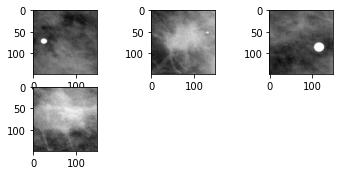

In [ ]:
images = range(0,4)
for i in images:
    plt.subplot(330 + 1 + i)
    plt.imshow(train_images[i], cmap=plt.get_cmap('gray'))
    
#Show the plot
plt.show()

In [ ]:
# Get abnormalities only 
train_images = remove_baseline(train_images)
train_labels = remove_baseline(train_labels)
test_images = remove_baseline(test_images)
test_labels = remove_baseline(test_labels)

# Mapping labels with standard index
train_labels = labels_mapping(train_labels)
test_labels = labels_mapping(test_labels)

# Suffle index (Previous dataset is ordered by index)
train_images, train_labels = shuffle_dataset(train_images, train_labels)
test_images, test_labels = shuffle_dataset(test_images, test_labels)

print("Train shape: ", train_images.shape)
print("Test shape: ", test_images.shape)

Train shape:  (2676, 150, 150)
Test shape:  (336, 150, 150)


Ben samples:  1568
Mal samples:  1108


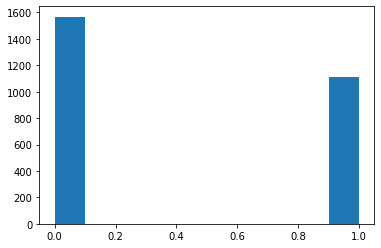

In [ ]:
#check if training dataset is balanced  
unique, counts = np.unique(train_labels, return_counts=True)
print("Ben samples: ", counts[0])
print("Mal samples: ", counts[1])
plt.hist(train_labels)
plt.show()

In [ ]:
#trainref_images=train_images
#trainref_labels=train_labels
trainref_images, trainref_labels = remove_ben(train_images,train_labels)
print(len(trainref_images))
print(len(trainref_labels)) 

2216
2216


Ben samples:  1108
Mal samples:  1108


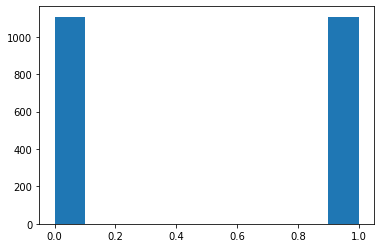

In [ ]:
#check if training dataset is balanced  
unique, counts = np.unique(trainref_labels, return_counts=True)
print("Ben samples: ", counts[0])
print("Mal samples: ", counts[1])
plt.hist(trainref_labels)
plt.show()

In [ ]:
# Prepare the data with the expected format
train_images = train_images.reshape(train_images.shape + (1,))
test_images = test_images.reshape(test_images.shape + (1,))
trainref_images = trainref_images.reshape(trainref_images.shape + (1,))

print("Train shape: ", train_images.shape)
print("Test shape: ", test_images.shape)
print("Train refactor shape: ", trainref_images.shape)

Train shape:  (2676, 150, 150, 1)
Test shape:  (336, 150, 150, 1)
Train refactor shape:  (2216, 150, 150, 1)


In [ ]:
#Splitting training-validation with 80-20 %
split_index = int(0.8*len(train_images))
train_dataset_split = train_images[:split_index]
valid_dataset_split = train_images[split_index:]
train_labels_split = train_labels[:split_index]
valid_labels_split = train_labels[split_index:]

splitref_index = int(0.8*len(trainref_images))
trainref_dataset_split = trainref_images[:splitref_index]
validref_dataset_split = trainref_images[splitref_index:]
trainref_labels_split = trainref_labels[:splitref_index]
validref_labels_split = trainref_labels[splitref_index:]

print(train_dataset_split.shape)
print(valid_dataset_split.shape)
print(trainref_dataset_split.shape)
print(validref_dataset_split.shape)

(2140, 150, 150, 1)
(536, 150, 150, 1)
(1772, 150, 150, 1)
(444, 150, 150, 1)


In [ ]:
# All images will be rescaled by 1./65535 (max value range)
train_datagen = ImageDataGenerator(rescale=1./65535)
valid_datagen = ImageDataGenerator(rescale=1./65535)
trainref_datagen = ImageDataGenerator(rescale=1./65535)
validref_datagen = ImageDataGenerator(rescale=1./65535)
test_datagen = ImageDataGenerator(rescale=1./65535)

# **CNN Definition**

## Model 1
Simple model

In [ ]:
model1 = models.Sequential()
model1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(layers.Flatten())
model1.add(layers.Dense(64, activation="relu"))
model1.add(layers.Dense(1, activation='sigmoid'))

model1.compile(loss="binary_crossentropy",
              optimizer='rmsprop',
              metrics=METRICS)
              
model1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 34, 34, 64)        36928     
                                                                 
 flatten_5 (Flatten)         (None, 73984)            

In [ ]:
history1 = model1.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE)

Epoch 1/100
66/66 [==============================] - 4s 34ms/step - loss: 0.7796 - acc: 0.5598 - prec: 0.4013 - rec: 0.1430 - auc: 0.4928 - val_loss: 0.6828 - val_acc: 0.6094 - val_prec: 0.6406 - val_rec: 0.1881 - val_auc: 0.6609
Epoch 2/100
66/66 [==============================] - 2s 27ms/step - loss: 0.7023 - acc: 0.5920 - prec: 0.5410 - rec: 0.0382 - auc: 0.5142 - val_loss: 0.6917 - val_acc: 0.5742 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00 - val_auc: 0.5000
Epoch 3/100
66/66 [==============================] - 2s 27ms/step - loss: 0.6927 - acc: 0.5897 - prec: 0.6000 - rec: 0.0069 - auc: 0.5166 - val_loss: 0.6776 - val_acc: 0.5742 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00 - val_auc: 0.6392
Epoch 4/100
66/66 [==============================] - 2s 27ms/step - loss: 0.6871 - acc: 0.5911 - prec: 0.5208 - rec: 0.0577 - auc: 0.5580 - val_loss: 0.6762 - val_acc: 0.5391 - val_prec: 0.4724 - val_rec: 0.7064 - val_auc: 0.6325
Epoch 5/100
66/66 [==============================] - 2s 27ms/ste

In [ ]:
model1.save(os.path.join(MODEL_PATH,'benmal_model1.h5'))

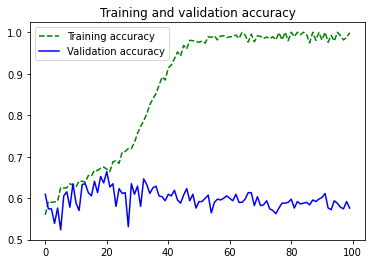

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history1)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'benmal_model1_acc.png'))

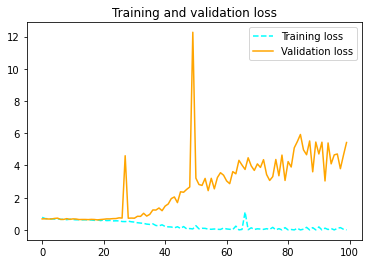

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history1)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model1_loss.png'))

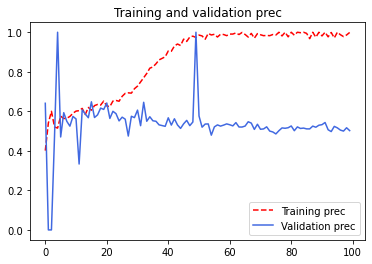

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_prec(history1)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'benmal_model1_prec.png'))

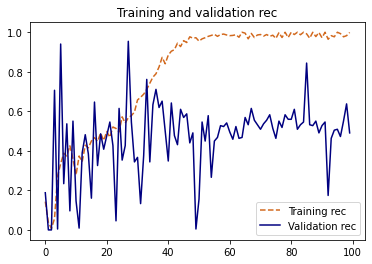

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_rec(history1)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model1_rec.png'))

In [ ]:
print_opt_results(history1)

Epoch [end]: 100
Epoch [opt]: 21
Valid accuracy [end]: 0.5762
Valid accuracy [opt]: 0.6641
Valid loss [end]: 5.4225
Valid loss [opt]: 0.6608
Valid precision [end]: 5.4225
Valid precision [opt]: 0.6420
Valid recall [end]: 0.5762
Valid recall [opt]: 0.4771


In [ ]:
test_model(model1)

10/10 [==============================] - 0s 12ms/step - loss: 5.7026 - acc: 0.5719 - prec: 0.4148 - rec: 0.4912 - auc: 0.5859

---------------------------------
Accuracy: 57.19 %
Loss: 5.70 %
Precision: 41.48 %
Recall: 49.12 %
AUC: 0.59
---------------------------------



## Data Augmentation

In [ ]:
# Train data augmentation. Deep Convolutional Neural Networks for breast cancer screening. Hiba Chougrada, Hamid Zouaki, Omar Alheyane b
train_datagen = ImageDataGenerator(
    rescale=1./65535,
    rotation_range=40,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.5,
    zoom_range=0.5, #0.5 - 1.5
    horizontal_flip=True,
    fill_mode='nearest')

## Model 1.1
Simple model with data augmentation

In [ ]:
model11 = models.Sequential()
model11.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model11.add(layers.MaxPooling2D((2, 2)))
model11.add(layers.Conv2D(64, (3, 3), activation='relu'))
model11.add(layers.MaxPooling2D((2, 2)))
model11.add(layers.Conv2D(64, (3, 3), activation='relu'))
model11.add(layers.Flatten())
model11.add(layers.Dense(64, activation="relu"))
model11.add(layers.Dense(1, activation='sigmoid'))

model11.compile(loss="binary_crossentropy",
              optimizer='rmsprop',
              metrics=METRICS)

model11.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 34, 34, 64)        36928     
                                                                 
 flatten_6 (Flatten)         (None, 73984)            

In [ ]:
history11 = model11.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE)

Epoch 1/100
66/66 [==============================] - 6s 76ms/step - loss: 0.9907 - acc: 0.5717 - prec: 0.4295 - rec: 0.2031 - auc: 0.5193 - val_loss: 0.7169 - val_acc: 0.4258 - val_prec: 0.4258 - val_rec: 1.0000 - val_auc: 0.6442
Epoch 2/100
66/66 [==============================] - 4s 67ms/step - loss: 0.7063 - acc: 0.5783 - prec: 0.4444 - rec: 0.0968 - auc: 0.4933 - val_loss: 0.6895 - val_acc: 0.5723 - val_prec: 0.4667 - val_rec: 0.0321 - val_auc: 0.4561
Epoch 3/100
66/66 [==============================] - 4s 66ms/step - loss: 0.6870 - acc: 0.5844 - prec: 0.3333 - rec: 0.0104 - auc: 0.4986 - val_loss: 0.6814 - val_acc: 0.5742 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00 - val_auc: 0.5232
Epoch 4/100
66/66 [==============================] - 4s 66ms/step - loss: 0.6893 - acc: 0.5650 - prec: 0.4427 - rec: 0.1947 - auc: 0.5288 - val_loss: 0.6821 - val_acc: 0.5742 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00 - val_auc: 0.5923
Epoch 5/100
66/66 [==============================] - 4s 67ms/ste

In [ ]:
model11.save(os.path.join(MODEL_PATH,'benmal_model11.h5'))

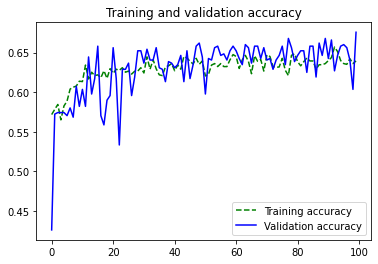

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history11)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'benmal_model11_acc.png'))

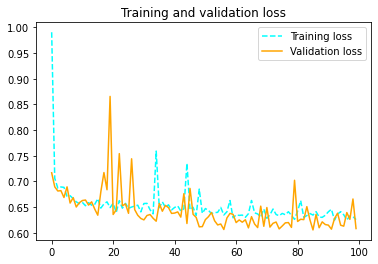

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history11)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model11_loss.png'))

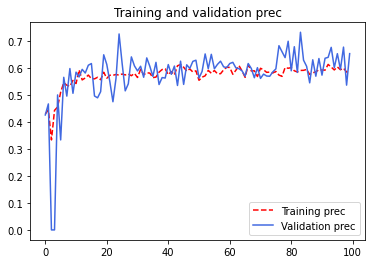

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_prec(history11)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model11_prec.png'))

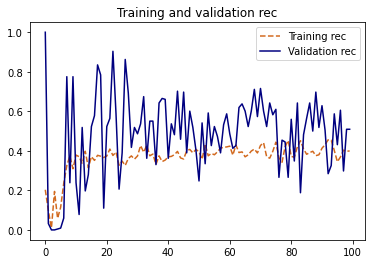

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_rec(history11)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model11_rec.png'))

In [ ]:
print_opt_results(history11)

Epoch [end]: 100
Epoch [opt]: 100
Valid accuracy [end]: 0.6758
Valid accuracy [opt]: 0.6758
Valid loss [end]: 0.6082
Valid loss [opt]: 0.6082
Valid precision [end]: 0.6082
Valid precision [opt]: 0.6529
Valid recall [end]: 0.6758
Valid recall [opt]: 0.5092


In [ ]:
test_model(model11)

10/10 [==============================] - 0s 12ms/step - loss: 0.6194 - acc: 0.6531 - prec: 0.5138 - rec: 0.4912 - auc: 0.6702

---------------------------------
Accuracy: 65.31 %
Loss: 0.62 %
Precision: 51.38 %
Recall: 49.12 %
AUC: 0.67
---------------------------------



## Balancing input data and Data Augmentation

In [ ]:
# Train data augmentation. Deep Convolutional Neural Networks for breast cancer screening. Hiba Chougrada, Hamid Zouaki, Omar Alheyane b
trainref_datagen = ImageDataGenerator(
    rescale=1./65535,
    rotation_range=40,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.5,
    zoom_range=0.5, #0.5 - 1.5
    horizontal_flip=True,
    fill_mode='nearest')

## Model 1.1.1
Simple model with data augmentation

In [ ]:
model111 = models.Sequential()
model111.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model111.add(layers.MaxPooling2D((2, 2)))
model111.add(layers.Conv2D(64, (3, 3), activation='relu'))
model111.add(layers.MaxPooling2D((2, 2)))
model111.add(layers.Conv2D(64, (3, 3), activation='relu'))
model111.add(layers.Flatten())
model111.add(layers.Dense(64, activation="relu"))
model111.add(layers.Dense(1, activation='sigmoid'))

model111.compile(loss="binary_crossentropy",
              optimizer='rmsprop',
              metrics=METRICS)

model111.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 34, 34, 64)        36928     
                                                                 
 flatten_7 (Flatten)         (None, 73984)            

In [ ]:
history111 = model111.fit(trainref_datagen.flow(trainref_dataset_split,
                                       trainref_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(trainref_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=validref_datagen.flow(validref_dataset_split,
                                       validref_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(validref_labels_split) // BATCH_SIZE)

Epoch 1/100
55/55 [==============================] - 6s 80ms/step - loss: 0.8708 - acc: 0.5854 - prec: 0.4745 - rec: 0.2464 - auc: 0.5266 - val_loss: 0.7147 - val_acc: 0.1683 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00 - val_auc: 0.5471
Epoch 2/100
55/55 [==============================] - 4s 67ms/step - loss: 0.7076 - acc: 0.5638 - prec: 0.3691 - rec: 0.0764 - auc: 0.5087 - val_loss: 0.7407 - val_acc: 0.1683 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00 - val_auc: 0.4575
Epoch 3/100
55/55 [==============================] - 4s 66ms/step - loss: 0.6856 - acc: 0.5805 - prec: 0.4651 - rec: 0.0552 - auc: 0.5228 - val_loss: 0.6708 - val_acc: 0.7115 - val_prec: 0.8466 - val_rec: 0.7977 - val_auc: 0.6359
Epoch 4/100
55/55 [==============================] - 4s 68ms/step - loss: 0.7040 - acc: 0.5856 - prec: 0.4984 - rec: 0.2181 - auc: 0.5456 - val_loss: 0.9784 - val_acc: 0.1683 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00 - val_auc: 0.6596
Epoch 5/100
55/55 [==============================] - 4s 

In [ ]:
model111.save(os.path.join(MODEL_PATH,'benmal_model111.h5'))

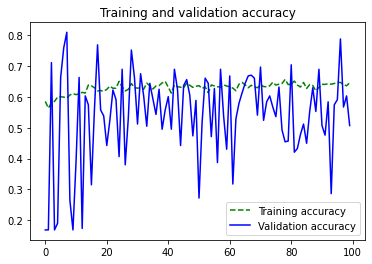

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history111)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'benmal_model111_acc.png'))

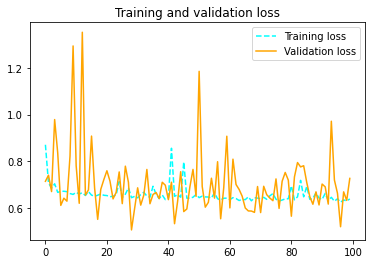

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history111)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model111_loss.png'))

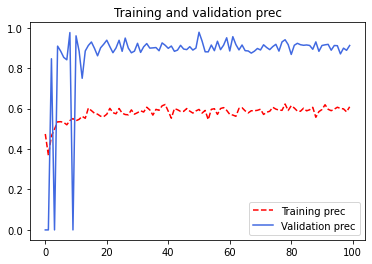

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_prec(history111)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model111_prec.png'))

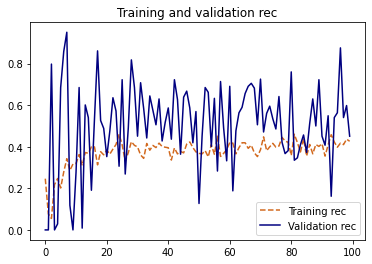

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_rec(history111)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model111_rec.png'))

In [ ]:
print_opt_results(history111)

Epoch [end]: 100
Epoch [opt]: 8
Valid accuracy [end]: 0.5072
Valid accuracy [opt]: 0.8101
Valid loss [end]: 0.7271
Valid loss [opt]: 0.6298
Valid precision [end]: 0.7271
Valid precision [opt]: 0.8414
Valid recall [end]: 0.5072
Valid recall [opt]: 0.9509


In [ ]:
test_model(model111)

10/10 [==============================] - 0s 12ms/step - loss: 0.6212 - acc: 0.6500 - prec: 0.5100 - rec: 0.4474 - auc: 0.6626

---------------------------------
Accuracy: 65.00 %
Loss: 0.62 %
Precision: 51.00 %
Recall: 44.74 %
AUC: 0.66
---------------------------------



##Class Weight

In [ ]:
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)

## Model 1.1.2
Simple model with data augmentation and weight balance

In [ ]:
model112 = models.Sequential()
model112.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model112.add(layers.MaxPooling2D((2, 2)))
model112.add(layers.Conv2D(64, (3, 3), activation='relu'))
model112.add(layers.MaxPooling2D((2, 2)))
model112.add(layers.Conv2D(64, (3, 3), activation='relu'))
model112.add(layers.Flatten())
model112.add(layers.Dense(64, activation="relu"))
model112.add(layers.Dense(1, activation='sigmoid'))

model112.compile(loss="binary_crossentropy",
              optimizer='rmsprop',
              metrics=METRICS)

model112.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_29 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 34, 34, 64)        36928     
                                                                 
 flatten_8 (Flatten)         (None, 73984)            

In [ ]:
history112 = model112.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    class_weight=dict(enumerate(class_weights)))

Epoch 1/100
66/66 [==============================] - 6s 74ms/step - loss: 0.8409 - acc: 0.4979 - prec: 0.4193 - rec: 0.6337 - auc: 0.5285 - val_loss: 0.7085 - val_acc: 0.4316 - val_prec: 0.4283 - val_rec: 1.0000 - val_auc: 0.6475
Epoch 2/100
66/66 [==============================] - 5s 69ms/step - loss: 0.6976 - acc: 0.5479 - prec: 0.4303 - rec: 0.3260 - auc: 0.5064 - val_loss: 0.7009 - val_acc: 0.4258 - val_prec: 0.4255 - val_rec: 0.9954 - val_auc: 0.6344
Epoch 3/100
66/66 [==============================] - 4s 67ms/step - loss: 0.6961 - acc: 0.5323 - prec: 0.4415 - rec: 0.5377 - auc: 0.5362 - val_loss: 0.6885 - val_acc: 0.5059 - val_prec: 0.4580 - val_rec: 0.8761 - val_auc: 0.6397
Epoch 4/100
66/66 [==============================] - 4s 68ms/step - loss: 0.6915 - acc: 0.5261 - prec: 0.4466 - rec: 0.6142 - auc: 0.5533 - val_loss: 0.7041 - val_acc: 0.4551 - val_prec: 0.4371 - val_rec: 0.9725 - val_auc: 0.6583
Epoch 5/100
66/66 [==============================] - 4s 66ms/step - loss: 0.6851

In [ ]:
model112.save(os.path.join(MODEL_PATH,'benmal_model112.h5'))

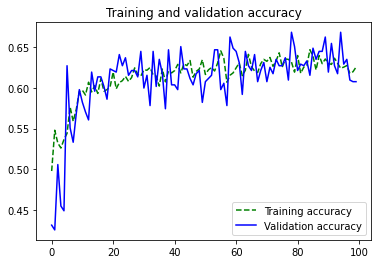

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history112)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'benmal_model112_acc.png'))

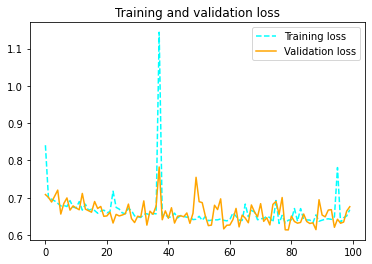

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history112)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model112_loss.png'))

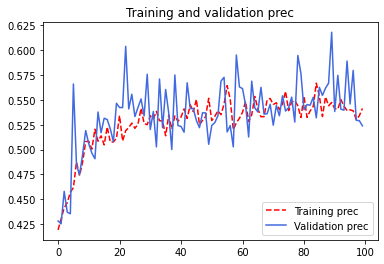

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_prec(history112)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model112_prec.png'))

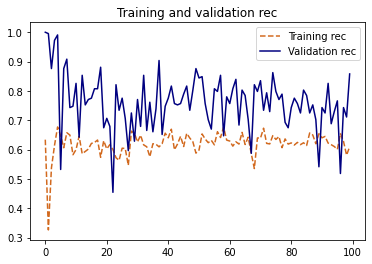

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_rec(history112)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model112_rec.png'))

In [ ]:
print_opt_results(history112)

Epoch [end]: 100
Epoch [opt]: 79
Valid accuracy [end]: 0.6074
Valid accuracy [opt]: 0.6680
Valid loss [end]: 0.6759
Valid loss [opt]: 0.6140
Valid precision [end]: 0.6759
Valid precision [opt]: 0.5945
Valid recall [end]: 0.6074
Valid recall [opt]: 0.6927


In [ ]:
test_model(model112)

10/10 [==============================] - 0s 13ms/step - loss: 0.7300 - acc: 0.5188 - prec: 0.4138 - rec: 0.8421 - auc: 0.6678

---------------------------------
Accuracy: 51.88 %
Loss: 0.73 %
Precision: 41.38 %
Recall: 84.21 %
AUC: 0.67
---------------------------------



## Model 1.2
Simple model with data augmentation and dropout



*   Dropout 0.5



In [ ]:
model12 = models.Sequential()
model12.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model12.add(layers.MaxPooling2D((2, 2)))
model12.add(layers.Conv2D(64, (3, 3), activation='relu'))
model12.add(layers.MaxPooling2D((2, 2)))
model12.add(layers.Conv2D(64, (3, 3), activation='relu'))
model12.add(layers.Flatten())
model12.add(layers.Dense(64, activation="relu"))
model12.add(layers.Dropout(0.5))
model12.add(layers.Dense(1, activation='sigmoid'))

model12.compile(loss="binary_crossentropy",
              optimizer='rmsprop',
              metrics=METRICS)

model12.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 34, 34, 64)        36928     
                                                                 
 flatten_9 (Flatten)         (None, 73984)            

In [ ]:
history12 = model12.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE)

Epoch 1/100
66/66 [==============================] - 6s 73ms/step - loss: 0.7627 - acc: 0.5564 - prec: 0.4227 - rec: 0.2492 - auc: 0.5127 - val_loss: 0.6881 - val_acc: 0.5742 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00 - val_auc: 0.3943
Epoch 2/100
66/66 [==============================] - 5s 69ms/step - loss: 0.6945 - acc: 0.5840 - prec: 0.4481 - rec: 0.0801 - auc: 0.5079 - val_loss: 0.6865 - val_acc: 0.5742 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00 - val_auc: 0.5457
Epoch 3/100
66/66 [==============================] - 4s 66ms/step - loss: 0.6995 - acc: 0.5816 - prec: 0.4414 - rec: 0.0564 - auc: 0.5172 - val_loss: 0.6786 - val_acc: 0.5742 - val_prec: 0.5000 - val_rec: 0.0275 - val_auc: 0.5028
Epoch 4/100
66/66 [==============================] - 4s 67ms/step - loss: 0.6857 - acc: 0.5792 - prec: 0.4321 - rec: 0.0809 - auc: 0.5154 - val_loss: 0.6925 - val_acc: 0.5742 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00 - val_auc: 0.4503
Epoch 5/100
66/66 [==============================] - 4s 

In [ ]:
model12.save(os.path.join(MODEL_PATH,'benmal_model12_d5.h5'))

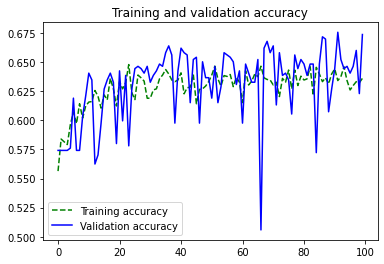

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history12)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'benmal_model12_acc.png'))

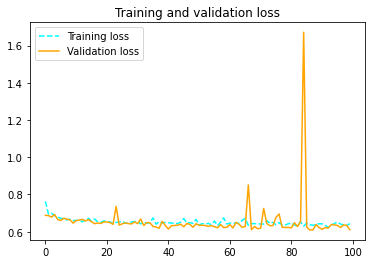

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history12)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model12_loss.png'))

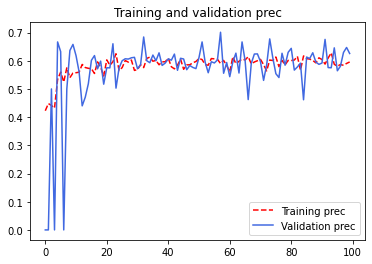

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_prec(history12)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model12_prec.png'))

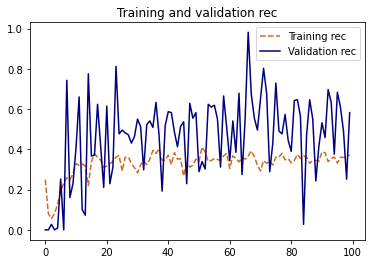

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_rec(history12)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model12_rec.png'))

In [ ]:
print_opt_results(history12)

Epoch [end]: 100
Epoch [opt]: 92
Valid accuracy [end]: 0.6738
Valid accuracy [opt]: 0.6758
Valid loss [end]: 0.6110
Valid loss [opt]: 0.6221
Valid precision [end]: 0.6110
Valid precision [opt]: 0.6757
Valid recall [end]: 0.6738
Valid recall [opt]: 0.4587


In [ ]:
test_model(model12)

10/10 [==============================] - 0s 11ms/step - loss: 0.6425 - acc: 0.6031 - prec: 0.4496 - rec: 0.5088 - auc: 0.6493

---------------------------------
Accuracy: 60.31 %
Loss: 0.64 %
Precision: 44.96 %
Recall: 50.88 %
AUC: 0.65
---------------------------------



###Model 1.2.2
*   Dropout 0.5 and weight 



In [ ]:
model122 = models.Sequential()
model122.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model122.add(layers.MaxPooling2D((2, 2)))
model122.add(layers.Conv2D(64, (3, 3), activation='relu'))
model122.add(layers.MaxPooling2D((2, 2)))
model122.add(layers.Conv2D(64, (3, 3), activation='relu'))
model122.add(layers.Flatten())
model122.add(layers.Dense(64, activation="relu"))
model122.add(layers.Dropout(0.5))
model122.add(layers.Dense(1, activation='sigmoid'))

model122.compile(loss="binary_crossentropy",
              optimizer='rmsprop',
              metrics=METRICS)

model122.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 34, 34, 64)        36928     
                                                                 
 flatten_10 (Flatten)        (None, 73984)           

In [ ]:
history122 = model122.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    class_weight=dict(enumerate(class_weights)))

Epoch 1/100
66/66 [==============================] - 6s 74ms/step - loss: 0.7473 - acc: 0.5037 - prec: 0.4108 - rec: 0.5173 - auc: 0.5248 - val_loss: 0.7025 - val_acc: 0.4336 - val_prec: 0.4289 - val_rec: 0.9954 - val_auc: 0.6330
Epoch 2/100
66/66 [==============================] - 5s 69ms/step - loss: 0.6993 - acc: 0.4929 - prec: 0.4257 - rec: 0.6552 - auc: 0.5343 - val_loss: 0.6951 - val_acc: 0.4688 - val_prec: 0.4430 - val_rec: 0.9633 - val_auc: 0.6379
Epoch 3/100
66/66 [==============================] - 4s 67ms/step - loss: 0.6970 - acc: 0.4820 - prec: 0.4161 - rec: 0.6539 - auc: 0.5207 - val_loss: 0.6893 - val_acc: 0.5742 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00 - val_auc: 0.5345
Epoch 4/100
66/66 [==============================] - 4s 67ms/step - loss: 0.6939 - acc: 0.5365 - prec: 0.4380 - rec: 0.4527 - auc: 0.5221 - val_loss: 0.6848 - val_acc: 0.5586 - val_prec: 0.4888 - val_rec: 0.8028 - val_auc: 0.6614
Epoch 5/100
66/66 [==============================] - 4s 67ms/step - loss

In [ ]:
model122.save(os.path.join(MODEL_PATH,'benmal_model122_d5.h5'))

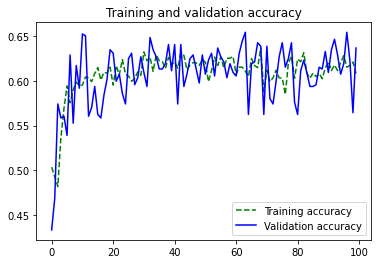

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history122)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'benmal_model122_acc.png'))

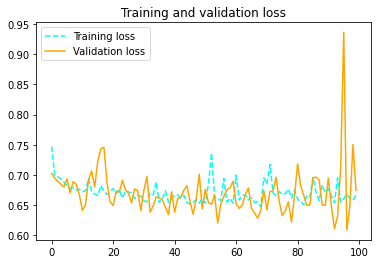

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history122)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model122_loss.png'))

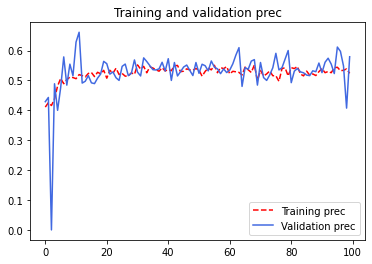

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_prec(history122)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model122_prec.png'))

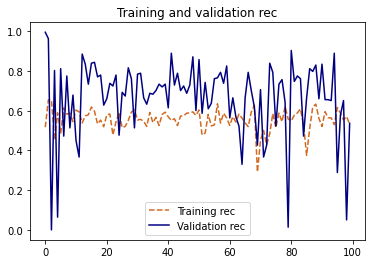

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_rec(history122)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model122_rec.png'))

In [ ]:
print_opt_results(history122)

Epoch [end]: 100
Epoch [opt]: 64
Valid accuracy [end]: 0.6367
Valid accuracy [opt]: 0.6543
Valid loss [end]: 0.6745
Valid loss [opt]: 0.6677
Valid precision [end]: 0.6745
Valid precision [opt]: 0.6096
Valid recall [end]: 0.6367
Valid recall [opt]: 0.5229


In [ ]:
test_model(model122)

10/10 [==============================] - 0s 11ms/step - loss: 0.7192 - acc: 0.5656 - prec: 0.4046 - rec: 0.4649 - auc: 0.5959

---------------------------------
Accuracy: 56.56 %
Loss: 0.72 %
Precision: 40.46 %
Recall: 46.49 %
AUC: 0.60
---------------------------------



##Model 1.3

*   Dropout 0.2



In [ ]:
model13 = models.Sequential()
model13.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model13.add(layers.MaxPooling2D((2, 2)))
model13.add(layers.Conv2D(64, (3, 3), activation='relu'))
model13.add(layers.MaxPooling2D((2, 2)))
model13.add(layers.Conv2D(64, (3, 3), activation='relu'))
model13.add(layers.Flatten())
model13.add(layers.Dense(64, activation="relu"))
model13.add(layers.Dropout(0.2))
model13.add(layers.Dense(1, activation='sigmoid'))

model13.compile(loss="binary_crossentropy",
              optimizer='rmsprop',
              metrics=METRICS)

model13.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_39 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 34, 34, 64)        36928     
                                                                 
 flatten_11 (Flatten)        (None, 73984)           

In [ ]:
history13 = model13.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE)

Epoch 1/100
66/66 [==============================] - 6s 72ms/step - loss: 0.7247 - acc: 0.5688 - prec: 0.4173 - rec: 0.1562 - auc: 0.5164 - val_loss: 0.6823 - val_acc: 0.5742 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00 - val_auc: 0.5131
Epoch 2/100
66/66 [==============================] - 4s 68ms/step - loss: 0.6853 - acc: 0.5787 - prec: 0.4348 - rec: 0.0926 - auc: 0.5187 - val_loss: 0.6698 - val_acc: 0.6094 - val_prec: 0.6500 - val_rec: 0.1789 - val_auc: 0.6518
Epoch 3/100
66/66 [==============================] - 4s 66ms/step - loss: 0.6776 - acc: 0.5944 - prec: 0.5200 - rec: 0.1651 - auc: 0.5565 - val_loss: 0.6538 - val_acc: 0.6445 - val_prec: 0.6731 - val_rec: 0.3211 - val_auc: 0.6510
Epoch 4/100
66/66 [==============================] - 4s 67ms/step - loss: 0.6700 - acc: 0.5982 - prec: 0.5249 - rec: 0.2434 - auc: 0.5830 - val_loss: 0.6668 - val_acc: 0.5918 - val_prec: 0.5849 - val_rec: 0.1422 - val_auc: 0.6406
Epoch 5/100
66/66 [==============================] - 4s 67ms/step - loss

In [ ]:
model13.save(os.path.join(MODEL_PATH,'benmal_model13.h5'))

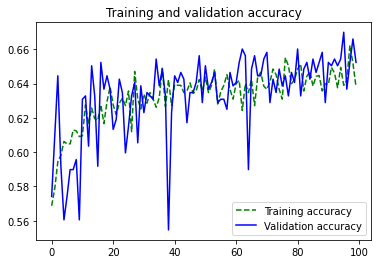

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history13)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'benmal_model13_acc.png'))

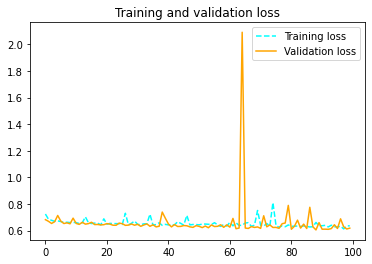

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history13)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model13_loss.png'))

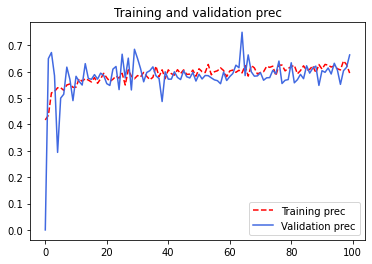

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_prec(history13)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model13_prec.png'))

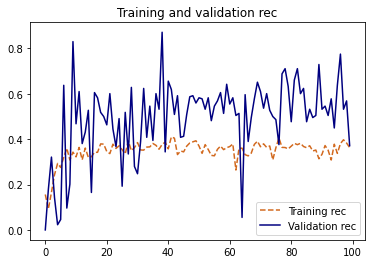

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_rec(history13)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model13_rec.png'))

In [ ]:
print_opt_results(history13)

Epoch [end]: 100
Epoch [opt]: 96
Valid accuracy [end]: 0.6523
Valid accuracy [opt]: 0.6699
Valid loss [end]: 0.6186
Valid loss [opt]: 0.6158
Valid precision [end]: 0.6186
Valid precision [opt]: 0.6070
Valid recall [end]: 0.6523
Valid recall [opt]: 0.6376


In [ ]:
test_model(model13)

10/10 [==============================] - 0s 12ms/step - loss: 0.6132 - acc: 0.6719 - prec: 0.5652 - rec: 0.3421 - auc: 0.6728

---------------------------------
Accuracy: 67.19 %
Loss: 0.61 %
Precision: 56.52 %
Recall: 34.21 %
AUC: 0.67
---------------------------------



##Model 1.3.2

*   Dropout 0.2 and weight



In [ ]:
model132 = models.Sequential()
model132.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model132.add(layers.MaxPooling2D((2, 2)))
model132.add(layers.Conv2D(64, (3, 3), activation='relu'))
model132.add(layers.MaxPooling2D((2, 2)))
model132.add(layers.Conv2D(64, (3, 3), activation='relu'))
model132.add(layers.Flatten())
model132.add(layers.Dense(64, activation="relu"))
model132.add(layers.Dropout(0.2))
model132.add(layers.Dense(1, activation='sigmoid'))

model132.compile(loss="binary_crossentropy",
              optimizer='rmsprop',
              metrics=METRICS)

model132.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_41 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_42 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_43 (Conv2D)          (None, 34, 34, 64)        36928     
                                                                 
 flatten_12 (Flatten)        (None, 73984)           

In [ ]:
history132 = model132.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    class_weight=dict(enumerate(class_weights)))

Epoch 1/100
66/66 [==============================] - 6s 74ms/step - loss: 0.8586 - acc: 0.5049 - prec: 0.4166 - rec: 0.5627 - auc: 0.5323 - val_loss: 0.6942 - val_acc: 0.5488 - val_prec: 0.3143 - val_rec: 0.0505 - val_auc: 0.4859
Epoch 2/100
66/66 [==============================] - 5s 69ms/step - loss: 0.7175 - acc: 0.5232 - prec: 0.4398 - rec: 0.5667 - auc: 0.5320 - val_loss: 0.7050 - val_acc: 0.4277 - val_prec: 0.4266 - val_rec: 1.0000 - val_auc: 0.6093
Epoch 3/100
66/66 [==============================] - 4s 68ms/step - loss: 0.6945 - acc: 0.5266 - prec: 0.4357 - rec: 0.5255 - auc: 0.5362 - val_loss: 0.7025 - val_acc: 0.4414 - val_prec: 0.4323 - val_rec: 0.9954 - val_auc: 0.6446
Epoch 4/100
66/66 [==============================] - 5s 68ms/step - loss: 0.6956 - acc: 0.5275 - prec: 0.4449 - rec: 0.6222 - auc: 0.5564 - val_loss: 0.6917 - val_acc: 0.6074 - val_prec: 0.5333 - val_rec: 0.6239 - val_auc: 0.6171
Epoch 5/100
66/66 [==============================] - 5s 68ms/step - loss: 0.6922

In [ ]:
model132.save(os.path.join(MODEL_PATH,'benmal_model132.h5'))

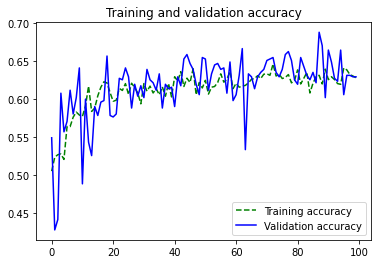

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history132)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'benmal_model132_acc.png'))

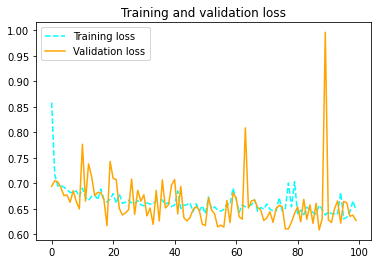

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history132)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model132_loss.png'))

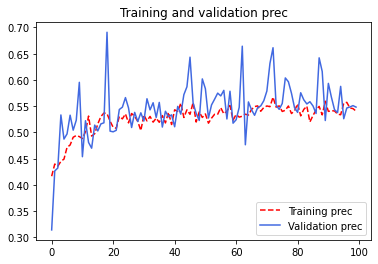

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_prec(history132)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model132_prec.png'))

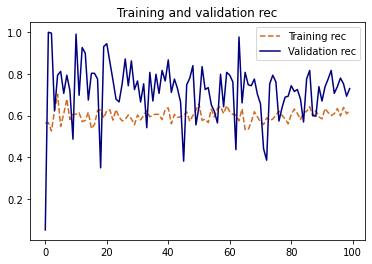

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_rec(history132)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model132_rec.png'))

In [ ]:
print_opt_results(history132)

Epoch [end]: 100
Epoch [opt]: 88
Valid accuracy [end]: 0.6289
Valid accuracy [opt]: 0.6875
Valid loss [end]: 0.6270
Valid loss [opt]: 0.6085
Valid precision [end]: 0.6270
Valid precision [opt]: 0.6422
Valid recall [end]: 0.6289
Valid recall [opt]: 0.6009


In [ ]:
test_model(model132)

10/10 [==============================] - 0s 13ms/step - loss: 0.6749 - acc: 0.6031 - prec: 0.4615 - rec: 0.6842 - auc: 0.6711

---------------------------------
Accuracy: 60.31 %
Loss: 0.67 %
Precision: 46.15 %
Recall: 68.42 %
AUC: 0.67
---------------------------------



##Model 1.4

*   Dropout 0.1



In [ ]:
model14 = models.Sequential()
model14.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model14.add(layers.MaxPooling2D((2, 2)))
model14.add(layers.Conv2D(64, (3, 3), activation='relu'))
model14.add(layers.MaxPooling2D((2, 2)))
model14.add(layers.Conv2D(64, (3, 3), activation='relu'))
model14.add(layers.Flatten())
model14.add(layers.Dense(64, activation="relu"))
model14.add(layers.Dropout(0.1))
model14.add(layers.Dense(1, activation='sigmoid'))

model14.compile(loss="binary_crossentropy",
              optimizer='rmsprop',
              metrics=METRICS)

model14.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_45 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 34, 34, 64)        36928     
                                                                 
 flatten_13 (Flatten)        (None, 73984)           

In [ ]:
history14 = model14.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE)

Epoch 1/100
66/66 [==============================] - 6s 74ms/step - loss: 0.8125 - acc: 0.5684 - prec: 0.4283 - rec: 0.2006 - auc: 0.4946 - val_loss: 0.6873 - val_acc: 0.5781 - val_prec: 0.6667 - val_rec: 0.0183 - val_auc: 0.4882
Epoch 2/100
66/66 [==============================] - 5s 69ms/step - loss: 0.6950 - acc: 0.5821 - prec: 0.4530 - rec: 0.0609 - auc: 0.5079 - val_loss: 0.6799 - val_acc: 0.5742 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00 - val_auc: 0.6163
Epoch 3/100
66/66 [==============================] - 4s 66ms/step - loss: 0.6912 - acc: 0.5754 - prec: 0.4094 - rec: 0.0703 - auc: 0.5416 - val_loss: 0.6727 - val_acc: 0.5781 - val_prec: 0.6667 - val_rec: 0.0183 - val_auc: 0.6281
Epoch 4/100
66/66 [==============================] - 4s 67ms/step - loss: 0.6760 - acc: 0.5972 - prec: 0.5279 - rec: 0.1859 - auc: 0.5652 - val_loss: 0.6610 - val_acc: 0.5801 - val_prec: 0.5556 - val_rec: 0.0688 - val_auc: 0.6533
Epoch 5/100
66/66 [==============================] - 4s 66ms/step - loss

In [ ]:
model14.save(os.path.join(MODEL_PATH,'benmal_model14.h5'))

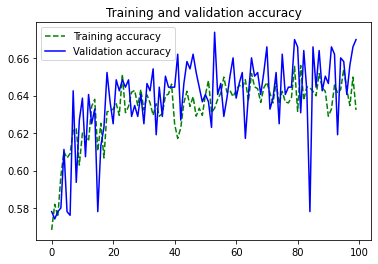

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history14)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'benmal_model14_acc.png'))

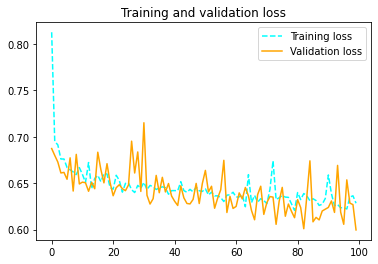

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history14)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model14_loss.png'))

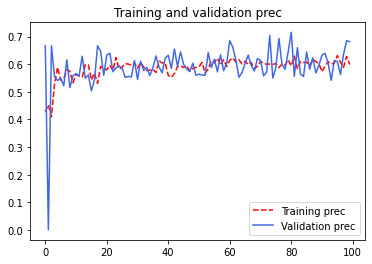

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_prec(history14)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model14_prec.png'))

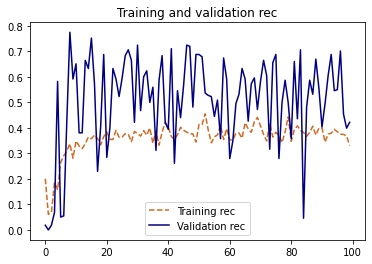

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_rec(history14)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model14_rec.png'))

In [ ]:
print_opt_results(history14)

Epoch [end]: 100
Epoch [opt]: 54
Valid accuracy [end]: 0.6699
Valid accuracy [opt]: 0.6738
Valid loss [end]: 0.5997
Valid loss [opt]: 0.6230
Valid precision [end]: 0.5997
Valid precision [opt]: 0.6425
Valid recall [end]: 0.6699
Valid recall [opt]: 0.5275


In [ ]:
test_model(model14)

10/10 [==============================] - 0s 12ms/step - loss: 0.6138 - acc: 0.6687 - prec: 0.5465 - rec: 0.4123 - auc: 0.6739

---------------------------------
Accuracy: 66.87 %
Loss: 0.61 %
Precision: 54.65 %
Recall: 41.23 %
AUC: 0.67
---------------------------------



##Model 1.4.2

*   Dropout 0.1 and weight



In [ ]:
model142 = models.Sequential()
model142.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model142.add(layers.MaxPooling2D((2, 2)))
model142.add(layers.Conv2D(64, (3, 3), activation='relu'))
model142.add(layers.MaxPooling2D((2, 2)))
model142.add(layers.Conv2D(64, (3, 3), activation='relu'))
model142.add(layers.Flatten())
model142.add(layers.Dense(64, activation="relu"))
model142.add(layers.Dropout(0.1))
model142.add(layers.Dense(1, activation='sigmoid'))

model142.compile(loss="binary_crossentropy",
              optimizer='rmsprop',
              metrics=METRICS)

model142.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_47 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_48 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (None, 34, 34, 64)        36928     
                                                                 
 flatten_14 (Flatten)        (None, 73984)           

In [ ]:
history142 = model142.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    class_weight=dict(enumerate(class_weights)))

Epoch 1/100
66/66 [==============================] - 6s 74ms/step - loss: 0.9103 - acc: 0.4975 - prec: 0.4164 - rec: 0.6039 - auc: 0.5334 - val_loss: 0.6925 - val_acc: 0.5215 - val_prec: 0.4670 - val_rec: 0.8761 - val_auc: 0.6206
Epoch 2/100
66/66 [==============================] - 4s 67ms/step - loss: 0.7104 - acc: 0.5342 - prec: 0.3828 - rec: 0.2208 - auc: 0.4821 - val_loss: 2.0920 - val_acc: 0.4258 - val_prec: 0.4258 - val_rec: 1.0000 - val_auc: 0.6441
Epoch 3/100
66/66 [==============================] - 4s 66ms/step - loss: 0.7192 - acc: 0.4587 - prec: 0.4186 - rec: 0.8088 - auc: 0.5105 - val_loss: 0.6942 - val_acc: 0.4473 - val_prec: 0.4346 - val_rec: 0.9908 - val_auc: 0.6349
Epoch 4/100
66/66 [==============================] - 4s 66ms/step - loss: 0.6943 - acc: 0.4953 - prec: 0.4253 - rec: 0.6273 - auc: 0.5253 - val_loss: 0.6671 - val_acc: 0.5742 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00 - val_auc: 0.6341
Epoch 5/100
66/66 [==============================] - 4s 66ms/step - loss

In [ ]:
model142.save(os.path.join(MODEL_PATH,'benmal_model142.h5'))

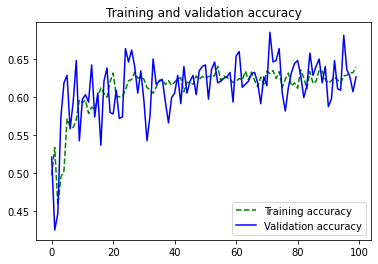

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history142)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'benmal_model142_acc.png'))

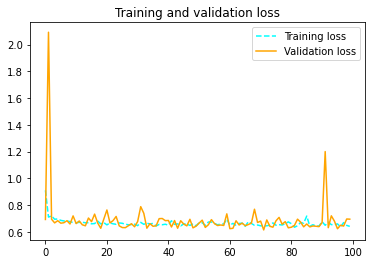

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history142)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model142_loss.png'))

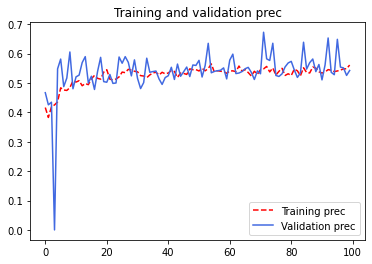

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_prec(history142)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model142_prec.png'))

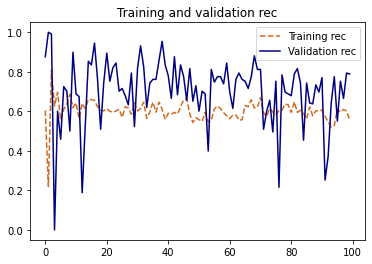

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_rec(history142)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model142_rec.png'))

In [ ]:
print_opt_results(history142)

Epoch [end]: 100
Epoch [opt]: 72
Valid accuracy [end]: 0.6270
Valid accuracy [opt]: 0.6855
Valid loss [end]: 0.6948
Valid loss [opt]: 0.6145
Valid precision [end]: 0.6948
Valid precision [opt]: 0.6727
Valid recall [end]: 0.6270
Valid recall [opt]: 0.5092


In [ ]:
test_model(model142)

10/10 [==============================] - 0s 11ms/step - loss: 0.7843 - acc: 0.5219 - prec: 0.4133 - rec: 0.8158 - auc: 0.6718

---------------------------------
Accuracy: 52.19 %
Loss: 0.78 %
Precision: 41.33 %
Recall: 81.58 %
AUC: 0.67
---------------------------------



## Model 2
More complex model with dropout 0.2

In [ ]:
model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.Flatten())
model2.add(layers.Dense(64, activation="relu"))
model2.add(layers.Dropout(0.2))
model2.add(layers.Dense(1, activation='sigmoid'))

model2.compile(loss="binary_crossentropy",
              optimizer='rmsprop',
              metrics=METRICS)

model2.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_50 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_51 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_52 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 flatten_15 (Flatten)        (None, 147968)          

In [ ]:
history2 = model2.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE)

Epoch 1/100
66/66 [==============================] - 6s 75ms/step - loss: 0.7637 - acc: 0.5667 - prec: 0.4448 - rec: 0.2959 - auc: 0.5347 - val_loss: 0.6924 - val_acc: 0.4844 - val_prec: 0.4506 - val_rec: 0.9633 - val_auc: 0.6436
Epoch 2/100
66/66 [==============================] - 5s 69ms/step - loss: 0.6911 - acc: 0.5811 - prec: 0.4595 - rec: 0.0979 - auc: 0.5333 - val_loss: 0.6670 - val_acc: 0.5762 - val_prec: 1.0000 - val_rec: 0.0046 - val_auc: 0.6418
Epoch 3/100
66/66 [==============================] - 4s 66ms/step - loss: 0.6847 - acc: 0.5882 - prec: 0.5000 - rec: 0.1993 - auc: 0.5347 - val_loss: 0.6785 - val_acc: 0.5645 - val_prec: 0.4324 - val_rec: 0.0734 - val_auc: 0.6303
Epoch 4/100
66/66 [==============================] - 4s 66ms/step - loss: 0.6763 - acc: 0.5830 - prec: 0.4887 - rec: 0.2230 - auc: 0.5594 - val_loss: 0.7046 - val_acc: 0.4590 - val_prec: 0.4387 - val_rec: 0.9679 - val_auc: 0.6643
Epoch 5/100
66/66 [==============================] - 4s 66ms/step - loss: 0.6754

In [ ]:
model2.save(os.path.join(MODEL_PATH,'benmal_model2.h5'))

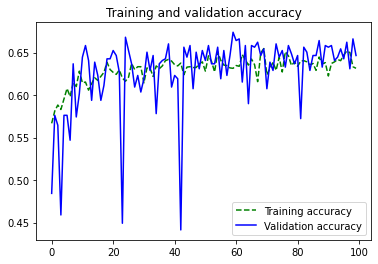

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history2)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'benmal_model2_acc.png'))

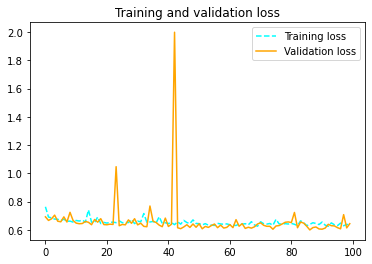

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history2)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model2_loss.png'))

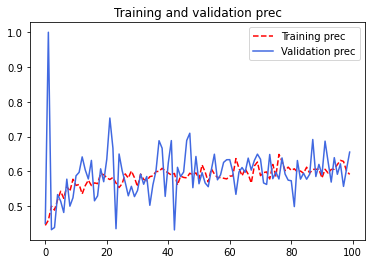

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_prec(history2)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model2_prec.png'))

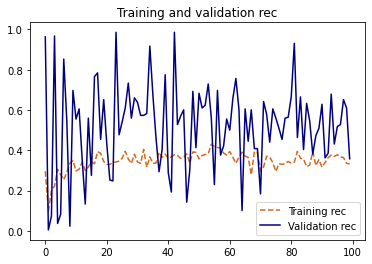

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_rec(history2)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model2_rec.png'))

In [ ]:
print_opt_results(history2)

Epoch [end]: 100
Epoch [opt]: 60
Valid accuracy [end]: 0.6465
Valid accuracy [opt]: 0.6738
Valid loss [end]: 0.6440
Valid loss [opt]: 0.6179
Valid precision [end]: 0.6440
Valid precision [opt]: 0.6335
Valid recall [end]: 0.6465
Valid recall [opt]: 0.5550


In [ ]:
test_model(model2)

10/10 [==============================] - 0s 12ms/step - loss: 0.6383 - acc: 0.6438 - prec: 0.5000 - rec: 0.2982 - auc: 0.6381

---------------------------------
Accuracy: 64.38 %
Loss: 0.64 %
Precision: 50.00 %
Recall: 29.82 %
AUC: 0.64
---------------------------------



## Model 2.1
More complex model with dropout 0.2 and weight

In [ ]:
model21 = models.Sequential()
model21.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model21.add(layers.MaxPooling2D((2, 2)))
model21.add(layers.Conv2D(64, (3, 3), activation='relu'))
model21.add(layers.MaxPooling2D((2, 2)))
model21.add(layers.Conv2D(128, (3, 3), activation='relu'))
model21.add(layers.Flatten())
model21.add(layers.Dense(64, activation="relu"))
model21.add(layers.Dropout(0.2))
model21.add(layers.Dense(1, activation='sigmoid'))

model21.compile(loss="binary_crossentropy",
              optimizer='rmsprop',
              metrics=METRICS)

model2.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_50 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_51 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_52 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 flatten_15 (Flatten)        (None, 147968)          

In [ ]:
history21 = model21.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    class_weight=dict(enumerate(class_weights)))

Epoch 1/100
66/66 [==============================] - 6s 79ms/step - loss: 1.1477 - acc: 0.5313 - prec: 0.4252 - rec: 0.4582 - auc: 0.5212 - val_loss: 0.7061 - val_acc: 0.4316 - val_prec: 0.4283 - val_rec: 1.0000 - val_auc: 0.6386
Epoch 2/100
66/66 [==============================] - 5s 69ms/step - loss: 0.7212 - acc: 0.5308 - prec: 0.4184 - rec: 0.3676 - auc: 0.5171 - val_loss: 0.6851 - val_acc: 0.5312 - val_prec: 0.4719 - val_rec: 0.8486 - val_auc: 0.6318
Epoch 3/100
66/66 [==============================] - 5s 70ms/step - loss: 0.7245 - acc: 0.5062 - prec: 0.4329 - rec: 0.6208 - auc: 0.5428 - val_loss: 0.6886 - val_acc: 0.6113 - val_prec: 0.5338 - val_rec: 0.6881 - val_auc: 0.6412
Epoch 4/100
66/66 [==============================] - 5s 70ms/step - loss: 0.6928 - acc: 0.5436 - prec: 0.4579 - rec: 0.6169 - auc: 0.5644 - val_loss: 0.6743 - val_acc: 0.5762 - val_prec: 0.6000 - val_rec: 0.0138 - val_auc: 0.6155
Epoch 5/100
66/66 [==============================] - 4s 68ms/step - loss: 0.6881

In [ ]:
model21.save(os.path.join(MODEL_PATH,'benmal_model21.h5'))

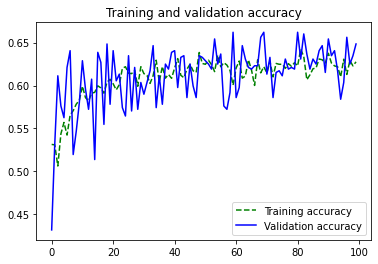

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history21)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'benmal_model21_acc.png'))

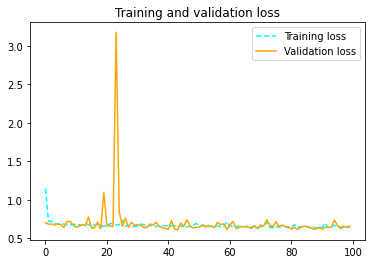

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history21)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model21_loss.png'))

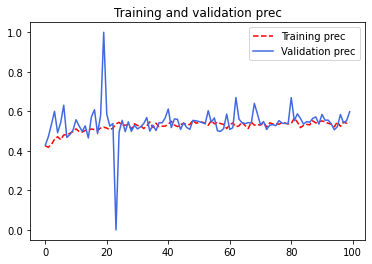

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_prec(history21)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model21_prec.png'))

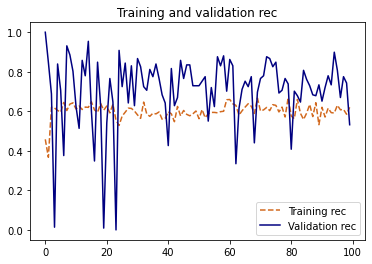

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_rec(history21)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model21_rec.png'))

In [ ]:
print_opt_results(history21)

Epoch [end]: 100
Epoch [opt]: 60
Valid accuracy [end]: 0.6484
Valid accuracy [opt]: 0.6621
Valid loss [end]: 0.6651
Valid loss [opt]: 0.6138
Valid precision [end]: 0.6651
Valid precision [opt]: 0.5862
Valid recall [end]: 0.6484
Valid recall [opt]: 0.7018


In [ ]:
test_model(model21)

10/10 [==============================] - 0s 14ms/step - loss: 0.6827 - acc: 0.6219 - prec: 0.4711 - rec: 0.5000 - auc: 0.6329

---------------------------------
Accuracy: 62.19 %
Loss: 0.68 %
Precision: 47.11 %
Recall: 50.00 %
AUC: 0.63
---------------------------------



## Model 3
More complex (added a layer to cnn) model with dropout 0.2

###Model 3.0

In [ ]:
model3 = models.Sequential()
model3.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(128, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(128, (3, 3), activation='relu'))
model3.add(layers.Flatten())
model3.add(layers.Dense(64, activation="relu"))
model3.add(layers.Dropout(0.2))
model3.add(layers.Dense(1, activation='sigmoid'))

model3.compile(loss="binary_crossentropy",
              optimizer='rmsprop',
              metrics=METRICS)

model3.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_56 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_57 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_58 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 17, 17, 128)    

In [ ]:
history3 = model3.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE)

Epoch 1/100
66/66 [==============================] - 7s 76ms/step - loss: 0.7639 - acc: 0.5774 - prec: 0.4172 - rec: 0.1237 - auc: 0.4906 - val_loss: 0.6865 - val_acc: 0.5742 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00 - val_auc: 0.3549
Epoch 2/100
66/66 [==============================] - 5s 68ms/step - loss: 0.6881 - acc: 0.5849 - prec: 0.3158 - rec: 0.0069 - auc: 0.4930 - val_loss: 0.6834 - val_acc: 0.5742 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00 - val_auc: 0.5977
Epoch 3/100
66/66 [==============================] - 4s 66ms/step - loss: 0.6809 - acc: 0.5840 - prec: 0.4560 - rec: 0.0658 - auc: 0.5141 - val_loss: 0.6777 - val_acc: 0.5742 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00 - val_auc: 0.6244
Epoch 4/100
66/66 [==============================] - 4s 68ms/step - loss: 0.6835 - acc: 0.5854 - prec: 0.0000e+00 - rec: 0.0000e+00 - auc: 0.5100 - val_loss: 0.6865 - val_acc: 0.5742 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00 - val_auc: 0.5096
Epoch 5/100
66/66 [=====================

In [ ]:
model3.save(os.path.join(MODEL_PATH,'benmal_model3.h5'))

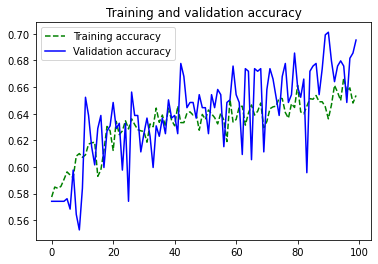

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history3)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'benmal_model3_acc.png'))

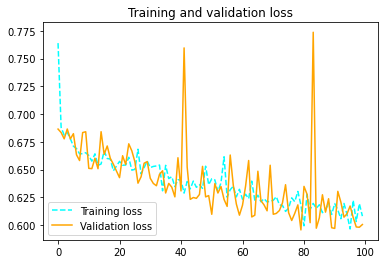

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history3)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model3_loss.png'))

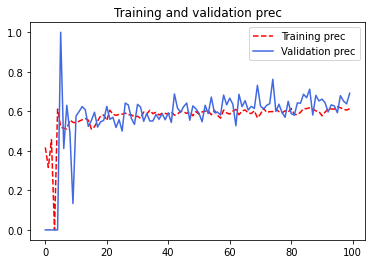

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_prec(history3)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model3_prec.png'))

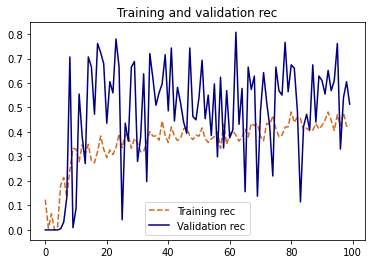

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_rec(history3)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model3_rec.png'))

In [ ]:
print_opt_results(history3)

Epoch [end]: 100
Epoch [opt]: 91
Valid accuracy [end]: 0.6953
Valid accuracy [opt]: 0.7012
Valid loss [end]: 0.6004
Valid loss [opt]: 0.5969
Valid precision [end]: 0.6004
Valid precision [opt]: 0.6617
Valid recall [end]: 0.6953
Valid recall [opt]: 0.6101


In [ ]:
test_model(model3)

10/10 [==============================] - 0s 12ms/step - loss: 0.5932 - acc: 0.6812 - prec: 0.5600 - rec: 0.4912 - auc: 0.6847

---------------------------------
Accuracy: 68.12 %
Loss: 0.59 %
Precision: 56.00 %
Recall: 49.12 %
AUC: 0.68
---------------------------------



### Model 3.1
More complex (added more node to last layer cnn) model with dropout 0.2

In [ ]:
model31 = models.Sequential()
model31.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model31.add(layers.MaxPooling2D((2, 2)))
model31.add(layers.Conv2D(64, (3, 3), activation='relu'))
model31.add(layers.MaxPooling2D((2, 2)))
model31.add(layers.Conv2D(128, (3, 3), activation='relu'))
model31.add(layers.MaxPooling2D((2, 2)))
model31.add(layers.Conv2D(256, (3, 3), activation='relu'))
model31.add(layers.Flatten())
model31.add(layers.Dense(64, activation="relu"))
model31.add(layers.Dropout(0.2))
model31.add(layers.Dense(1, activation='sigmoid'))

model31.compile(loss="binary_crossentropy",
              optimizer='rmsprop',
              metrics=METRICS)

model31.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_61 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_62 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 17, 17, 128)    

In [ ]:
history31 = model31.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE)

Epoch 1/100
66/66 [==============================] - 6s 75ms/step - loss: 0.7455 - acc: 0.5807 - prec: 0.4458 - rec: 0.1507 - auc: 0.5300 - val_loss: 0.6826 - val_acc: 0.5742 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00 - val_auc: 0.5526
Epoch 2/100
66/66 [==============================] - 4s 67ms/step - loss: 0.6818 - acc: 0.5849 - prec: 0.4508 - rec: 0.0637 - auc: 0.5205 - val_loss: 0.6799 - val_acc: 0.5742 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00 - val_auc: 0.6345
Epoch 3/100
66/66 [==============================] - 4s 67ms/step - loss: 0.6796 - acc: 0.5906 - prec: 0.5143 - rec: 0.0830 - auc: 0.5418 - val_loss: 0.7165 - val_acc: 0.4453 - val_prec: 0.4335 - val_rec: 0.9862 - val_auc: 0.6502
Epoch 4/100
66/66 [==============================] - 4s 66ms/step - loss: 0.6772 - acc: 0.5783 - prec: 0.4763 - rec: 0.2195 - auc: 0.5609 - val_loss: 0.6740 - val_acc: 0.5762 - val_prec: 1.0000 - val_rec: 0.0046 - val_auc: 0.6470
Epoch 5/100
66/66 [==============================] - 4s 67ms/ste

In [ ]:
model31.save(os.path.join(MODEL_PATH,'benmal_model31.h5'))

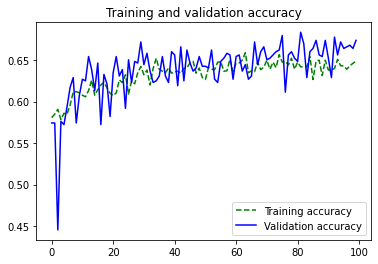

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history31)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'benmal_model31_acc.png'))

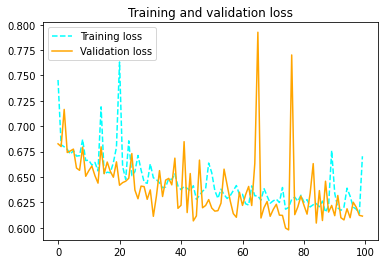

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history31)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model31_loss.png'))

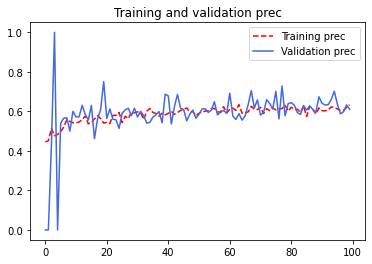

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_prec(history31)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model31_prec.png'))

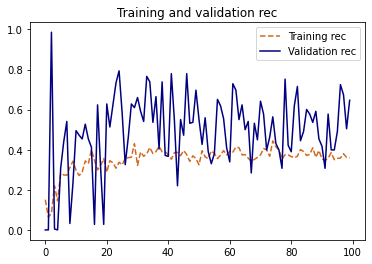

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_rec(history31)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model31_rec.png'))

In [ ]:
print_opt_results(history31)

Epoch [end]: 100
Epoch [opt]: 82
Valid accuracy [end]: 0.6738
Valid accuracy [opt]: 0.6836
Valid loss [end]: 0.6114
Valid loss [opt]: 0.6133
Valid precision [end]: 0.6114
Valid precision [opt]: 0.6308
Valid recall [end]: 0.6738
Valid recall [opt]: 0.6193


In [ ]:
test_model(model31)

10/10 [==============================] - 0s 13ms/step - loss: 0.6296 - acc: 0.6500 - prec: 0.5075 - rec: 0.5965 - auc: 0.6821

---------------------------------
Accuracy: 65.00 %
Loss: 0.63 %
Precision: 50.75 %
Recall: 59.65 %
AUC: 0.68
---------------------------------



### Model 3.2
Model 3 with weight

In [ ]:
model32 = models.Sequential()
model32.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model32.add(layers.MaxPooling2D((2, 2)))
model32.add(layers.Conv2D(64, (3, 3), activation='relu'))
model32.add(layers.MaxPooling2D((2, 2)))
model32.add(layers.Conv2D(128, (3, 3), activation='relu'))
model32.add(layers.MaxPooling2D((2, 2)))
model32.add(layers.Conv2D(128, (3, 3), activation='relu'))
model32.add(layers.Flatten())
model32.add(layers.Dense(64, activation="relu"))
model32.add(layers.Dropout(0.2))
model32.add(layers.Dense(1, activation='sigmoid'))

model32.compile(loss="binary_crossentropy",
              optimizer='rmsprop',
              metrics=METRICS)

model32.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_64 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_65 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_66 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_47 (MaxPoolin  (None, 17, 17, 128)    

In [ ]:
history32 = model32.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    class_weight=dict(enumerate(class_weights)))

Epoch 1/100
66/66 [==============================] - 6s 77ms/step - loss: 0.7859 - acc: 0.4942 - prec: 0.4208 - rec: 0.6660 - auc: 0.5340 - val_loss: 0.6927 - val_acc: 0.5762 - val_prec: 1.0000 - val_rec: 0.0046 - val_auc: 0.5158
Epoch 2/100
66/66 [==============================] - 5s 71ms/step - loss: 0.6979 - acc: 0.5299 - prec: 0.4281 - rec: 0.4375 - auc: 0.5240 - val_loss: 0.6940 - val_acc: 0.4609 - val_prec: 0.4398 - val_rec: 0.9725 - val_auc: 0.6558
Epoch 3/100
66/66 [==============================] - 4s 67ms/step - loss: 0.6992 - acc: 0.5138 - prec: 0.4405 - rec: 0.6694 - auc: 0.5505 - val_loss: 0.6790 - val_acc: 0.5449 - val_prec: 0.4802 - val_rec: 0.8349 - val_auc: 0.6668
Epoch 4/100
66/66 [==============================] - 4s 66ms/step - loss: 0.6873 - acc: 0.5380 - prec: 0.4566 - rec: 0.6701 - auc: 0.5765 - val_loss: 0.7006 - val_acc: 0.4512 - val_prec: 0.4356 - val_rec: 0.9771 - val_auc: 0.6750
Epoch 5/100
66/66 [==============================] - 4s 66ms/step - loss: 0.6907

In [ ]:
model32.save(os.path.join(MODEL_PATH,'benmal_model32.h5'))

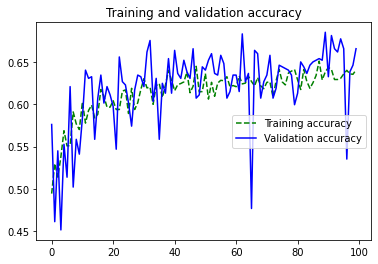

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history32)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'benmal_model32_acc.png'))

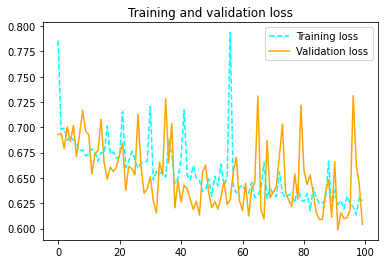

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history32)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model32_loss.png'))

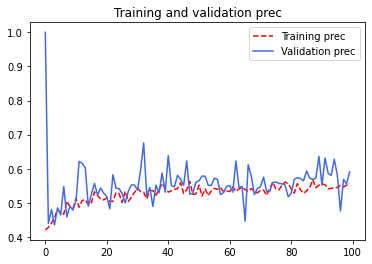

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_prec(history32)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model32_prec.png'))

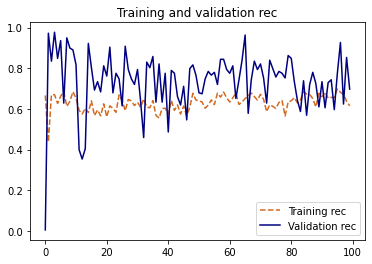

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_rec(history32)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model32_rec.png'))

In [ ]:
print_opt_results(history32)

Epoch [end]: 100
Epoch [opt]: 90
Valid accuracy [end]: 0.6660
Valid accuracy [opt]: 0.6855
Valid loss [end]: 0.6043
Valid loss [opt]: 0.6111
Valid precision [end]: 0.6043
Valid precision [opt]: 0.6364
Valid recall [end]: 0.6660
Valid recall [opt]: 0.6101


In [ ]:
test_model(model32)

10/10 [==============================] - 0s 12ms/step - loss: 0.6330 - acc: 0.6313 - prec: 0.4868 - rec: 0.6491 - auc: 0.7037

---------------------------------
Accuracy: 63.13 %
Loss: 0.63 %
Precision: 48.68 %
Recall: 64.91 %
AUC: 0.70
---------------------------------



### Model 3.3
Model 3.1 with weight

In [ ]:
model33 = models.Sequential()
model33.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model33.add(layers.MaxPooling2D((2, 2)))
model33.add(layers.Conv2D(64, (3, 3), activation='relu'))
model33.add(layers.MaxPooling2D((2, 2)))
model33.add(layers.Conv2D(128, (3, 3), activation='relu'))
model33.add(layers.MaxPooling2D((2, 2)))
model33.add(layers.Conv2D(256, (3, 3), activation='relu'))
model33.add(layers.Flatten())
model33.add(layers.Dense(64, activation="relu"))
model33.add(layers.Dropout(0.2))
model33.add(layers.Dense(1, activation='sigmoid'))

model33.compile(loss="binary_crossentropy",
              optimizer='rmsprop',
              metrics=METRICS)

model33.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 17, 17, 128)     

In [ ]:
history33 = model33.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    class_weight=dict(enumerate(class_weights)))

Epoch 1/100
66/66 [==============================] - 6s 75ms/step - loss: 0.7946 - acc: 0.5115 - prec: 0.4127 - rec: 0.5118 - auc: 0.5147 - val_loss: 0.6904 - val_acc: 0.6230 - val_prec: 0.6142 - val_rec: 0.3514 - val_auc: 0.5795
Epoch 2/100
66/66 [==============================] - 4s 67ms/step - loss: 0.6972 - acc: 0.4929 - prec: 0.4218 - rec: 0.6358 - auc: 0.5173 - val_loss: 0.6933 - val_acc: 0.4395 - val_prec: 0.4351 - val_rec: 0.9820 - val_auc: 0.6273
Epoch 3/100
66/66 [==============================] - 4s 66ms/step - loss: 0.6953 - acc: 0.5161 - prec: 0.4262 - rec: 0.5455 - auc: 0.5241 - val_loss: 0.6814 - val_acc: 0.5684 - val_prec: 0.5385 - val_rec: 0.0315 - val_auc: 0.6350
Epoch 4/100
66/66 [==============================] - 4s 66ms/step - loss: 0.6902 - acc: 0.5441 - prec: 0.4528 - rec: 0.5202 - auc: 0.5535 - val_loss: 0.7817 - val_acc: 0.5664 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00 - val_auc: 0.6281
Epoch 5/100
66/66 [==============================] - 4s 67ms/step - loss

In [ ]:
model33.save(os.path.join(MODEL_PATH,'benmal_model33.h5'))

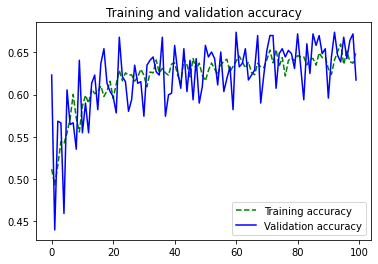

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history33)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'benmal_model33_acc.png'))

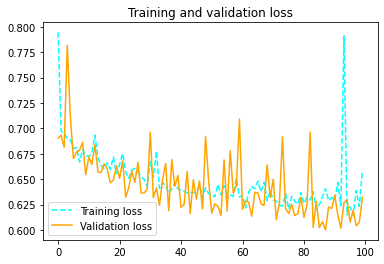

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history33)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model33_loss.png'))

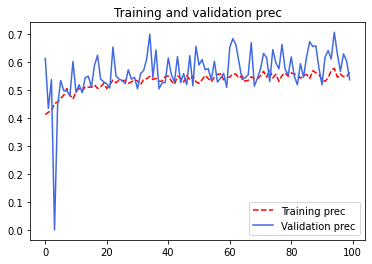

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_prec(history33)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model33_prec.png'))

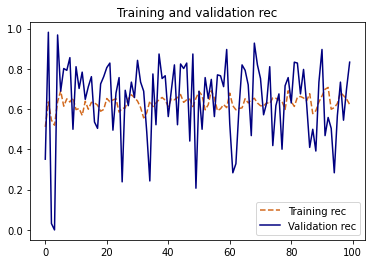

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_rec(history33)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model33_rec.png'))

In [ ]:
print_opt_results(history33)

Epoch [end]: 100
Epoch [opt]: 61
Valid accuracy [end]: 0.6172
Valid accuracy [opt]: 0.6738
Valid loss [end]: 0.6322
Valid loss [opt]: 0.6204
Valid precision [end]: 0.6322
Valid precision [opt]: 0.6536
Valid recall [end]: 0.6172
Valid recall [opt]: 0.5270


In [ ]:
test_model(model33)

10/10 [==============================] - 0s 14ms/step - loss: 0.6888 - acc: 0.5219 - prec: 0.4028 - rec: 0.7838 - auc: 0.6574

---------------------------------
Accuracy: 52.19 %
Loss: 0.69 %
Precision: 40.28 %
Recall: 78.38 %
AUC: 0.66
---------------------------------



## Model 4
Model 3.2 with more dense layer

In [ ]:
model4 = models.Sequential()
model4.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Conv2D(128, (3, 3), activation='relu'))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Conv2D(128, (3, 3), activation='relu'))
model4.add(layers.Flatten())
model4.add(layers.Dense(128, activation="relu"))
model4.add(layers.Dropout(0.2))
model4.add(layers.Dense(1, activation='sigmoid'))

model4.compile(loss="binary_crossentropy",
              optimizer='rmsprop',
              metrics=METRICS)

model4.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 17, 17, 128)     

In [ ]:
history4 = model4.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    class_weight=dict(enumerate(class_weights)))

Epoch 1/100
66/66 [==============================] - 6s 74ms/step - loss: 0.9499 - acc: 0.5751 - prec: 0.4891 - rec: 0.5190 - auc: 0.6019 - val_loss: 0.6941 - val_acc: 0.4395 - val_prec: 0.4354 - val_rec: 0.9865 - val_auc: 0.6233
Epoch 2/100
66/66 [==============================] - 5s 68ms/step - loss: 0.6992 - acc: 0.5128 - prec: 0.4163 - rec: 0.4866 - auc: 0.5164 - val_loss: 0.6811 - val_acc: 0.5840 - val_prec: 0.5181 - val_rec: 0.5811 - val_auc: 0.6318
Epoch 3/100
66/66 [==============================] - 4s 68ms/step - loss: 0.6965 - acc: 0.5166 - prec: 0.4332 - rec: 0.6000 - auc: 0.5413 - val_loss: 0.6921 - val_acc: 0.5000 - val_prec: 0.4621 - val_rec: 0.9324 - val_auc: 0.6435
Epoch 4/100
66/66 [==============================] - 4s 67ms/step - loss: 0.6922 - acc: 0.5493 - prec: 0.4621 - rec: 0.6076 - auc: 0.5691 - val_loss: 0.6889 - val_acc: 0.5176 - val_prec: 0.4710 - val_rec: 0.9144 - val_auc: 0.6471
Epoch 5/100
66/66 [==============================] - 4s 68ms/step - loss: 0.6889

In [ ]:
model4.save(os.path.join(MODEL_PATH,'benmal_model4.h5'))

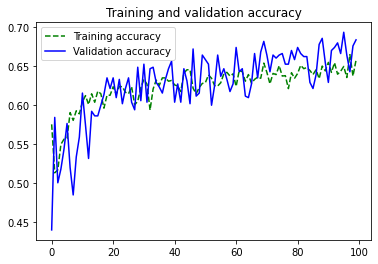

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history4)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'benmal_model4_acc.png'))

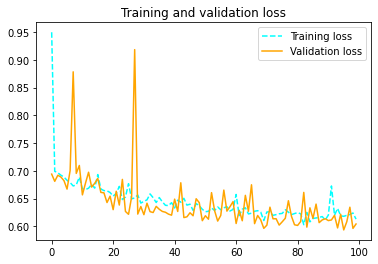

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history4)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model4_loss.png'))

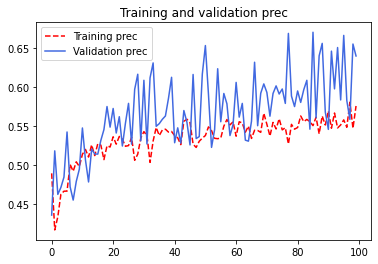

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_prec(history4)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model4_prec.png'))

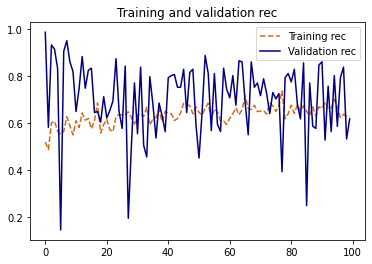

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_rec(history4)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model4_rec.png'))

In [ ]:
print_opt_results(history4)

Epoch [end]: 100
Epoch [opt]: 96
Valid accuracy [end]: 0.6836
Valid accuracy [opt]: 0.6934
Valid loss [end]: 0.6042
Valid loss [opt]: 0.5935
Valid precision [end]: 0.6042
Valid precision [opt]: 0.6667
Valid recall [end]: 0.6836
Valid recall [opt]: 0.5856


In [ ]:
test_model(model4)

10/10 [==============================] - 0s 13ms/step - loss: 0.6229 - acc: 0.6562 - prec: 0.5039 - rec: 0.5766 - auc: 0.6844

---------------------------------
Accuracy: 65.62 %
Loss: 0.62 %
Precision: 50.39 %
Recall: 57.66 %
AUC: 0.68
---------------------------------



## Model 5
Model 3.2 with another dense layer

In [ ]:
model5 = models.Sequential()
model5.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model5.add(layers.MaxPooling2D((2, 2)))
model5.add(layers.Conv2D(64, (3, 3), activation='relu'))
model5.add(layers.MaxPooling2D((2, 2)))
model5.add(layers.Conv2D(128, (3, 3), activation='relu'))
model5.add(layers.MaxPooling2D((2, 2)))
model5.add(layers.Conv2D(128, (3, 3), activation='relu'))
model5.add(layers.Flatten())
model5.add(layers.Dense(64, activation="relu"))
model5.add(layers.Dense(32, activation="relu"))
model5.add(layers.Dropout(0.2))
model5.add(layers.Dense(1, activation='sigmoid'))

model5.compile(loss="binary_crossentropy",
              optimizer='rmsprop',
              metrics=METRICS)

model5.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 17, 17, 128)     

In [ ]:
history5 = model5.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    class_weight=dict(enumerate(class_weights)))

Epoch 1/100
66/66 [==============================] - 6s 75ms/step - loss: 0.6989 - acc: 0.5552 - prec: 0.4251 - rec: 0.3285 - auc: 0.5384 - val_loss: 0.6915 - val_acc: 0.5684 - val_prec: 0.6667 - val_rec: 0.0090 - val_auc: 0.5661
Epoch 2/100
66/66 [==============================] - 4s 67ms/step - loss: 0.6947 - acc: 0.5038 - prec: 0.3870 - rec: 0.3654 - auc: 0.4756 - val_loss: 0.6933 - val_acc: 0.4395 - val_prec: 0.4361 - val_rec: 1.0000 - val_auc: 0.6249
Epoch 3/100
66/66 [==============================] - 4s 68ms/step - loss: 0.6927 - acc: 0.5261 - prec: 0.4107 - rec: 0.3749 - auc: 0.4930 - val_loss: 0.6981 - val_acc: 0.4336 - val_prec: 0.4336 - val_rec: 1.0000 - val_auc: 0.6319
Epoch 4/100
66/66 [==============================] - 4s 68ms/step - loss: 0.6961 - acc: 0.5213 - prec: 0.4292 - rec: 0.5256 - auc: 0.5416 - val_loss: 0.6809 - val_acc: 0.5703 - val_prec: 1.0000 - val_rec: 0.0090 - val_auc: 0.5848
Epoch 5/100
66/66 [==============================] - 4s 67ms/step - loss: 0.6977

In [ ]:
model5.save(os.path.join(MODEL_PATH,'benmal_model5.h5'))

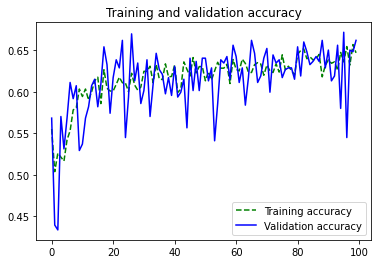

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history5)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'benmal_model5_acc.png'))

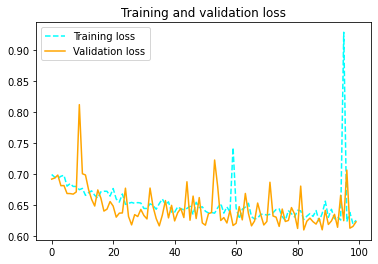

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history5)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model5_loss.png'))

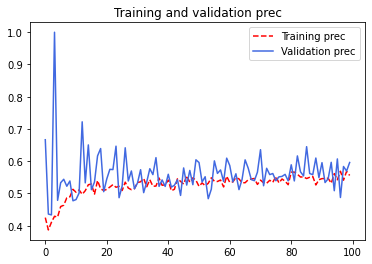

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_prec(history5)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model5_prec.png'))

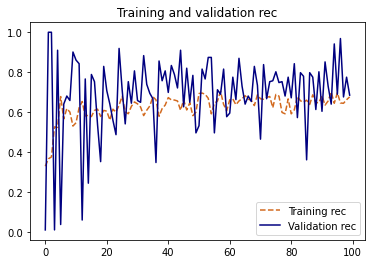

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_rec(history5)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model5_rec.png'))

In [ ]:
print_opt_results(history5)

Epoch [end]: 100
Epoch [opt]: 96
Valid accuracy [end]: 0.6621
Valid accuracy [opt]: 0.6719
Valid loss [end]: 0.6226
Valid loss [opt]: 0.6244
Valid precision [end]: 0.6226
Valid precision [opt]: 0.6071
Valid recall [end]: 0.6621
Valid recall [opt]: 0.6892


In [ ]:
test_model(model5)

10/10 [==============================] - 0s 14ms/step - loss: 0.6554 - acc: 0.6219 - prec: 0.4679 - rec: 0.6577 - auc: 0.6707

---------------------------------
Accuracy: 62.19 %
Loss: 0.66 %
Precision: 46.79 %
Recall: 65.77 %
AUC: 0.67
---------------------------------



## Model 6
Model 3.2 with dropout 0.5

In [ ]:
model6 = models.Sequential()
model6.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model6.add(layers.MaxPooling2D((2, 2)))
model6.add(layers.Conv2D(64, (3, 3), activation='relu'))
model6.add(layers.MaxPooling2D((2, 2)))
model6.add(layers.Conv2D(128, (3, 3), activation='relu'))
model6.add(layers.MaxPooling2D((2, 2)))
model6.add(layers.Conv2D(128, (3, 3), activation='relu'))
model6.add(layers.Flatten())
model6.add(layers.Dense(64, activation="relu"))

model6.add(layers.Dense(1, activation='sigmoid'))

model6.compile(loss="binary_crossentropy",
              optimizer='rmsprop',
              metrics=METRICS)

model6.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_42 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 17, 17, 128)    

In [ ]:
history6 = model6.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    class_weight=dict(enumerate(class_weights)))

Epoch 1/100
66/66 [==============================] - 6s 75ms/step - loss: 0.7858 - acc: 0.4934 - prec: 0.4055 - rec: 0.5726 - auc: 0.5164 - val_loss: 0.6901 - val_acc: 0.5664 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00 - val_auc: 0.4237
Epoch 2/100
66/66 [==============================] - 4s 68ms/step - loss: 0.7010 - acc: 0.5394 - prec: 0.4025 - rec: 0.2584 - auc: 0.4901 - val_loss: 0.6911 - val_acc: 0.5664 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00 - val_auc: 0.6080
Epoch 3/100
66/66 [==============================] - 4s 68ms/step - loss: 0.6929 - acc: 0.5380 - prec: 0.4225 - rec: 0.3722 - auc: 0.5031 - val_loss: 0.6841 - val_acc: 0.5664 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00 - val_auc: 0.6047
Epoch 4/100
66/66 [==============================] - 4s 67ms/step - loss: 0.6949 - acc: 0.5327 - prec: 0.4396 - rec: 0.5238 - auc: 0.5352 - val_loss: 0.6831 - val_acc: 0.5684 - val_prec: 0.5556 - val_rec: 0.0225 - val_auc: 0.6217
Epoch 5/100
66/66 [==============================] - 4s 

In [ ]:
model6.save(os.path.join(MODEL_PATH,'benmal_model6.h5'))

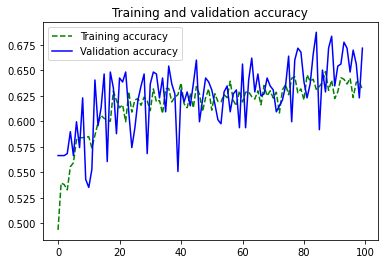

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history6)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'benmal_model6_acc.png'))

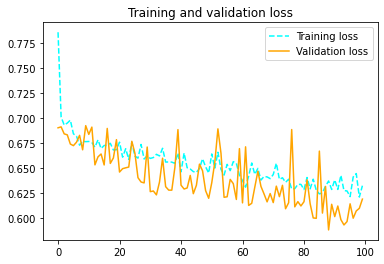

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history6)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model6_loss.png'))

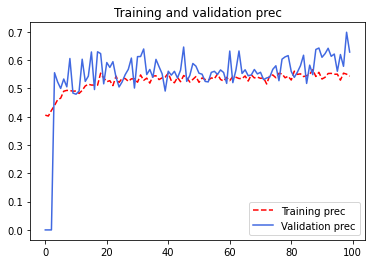

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_prec(history6)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model6_prec.png'))

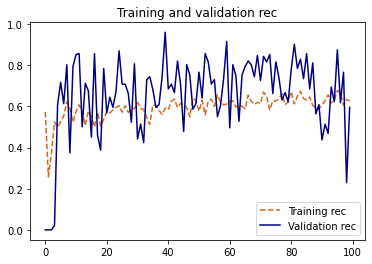

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_rec(history6)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model6_rec.png'))

In [ ]:
print_opt_results(history6)

Epoch [end]: 100
Epoch [opt]: 85
Valid accuracy [end]: 0.6719
Valid accuracy [opt]: 0.6875
Valid loss [end]: 0.6188
Valid loss [opt]: 0.5995
Valid precision [end]: 0.6188
Valid precision [opt]: 0.6174
Valid recall [end]: 0.6719
Valid recall [opt]: 0.7342


In [ ]:
test_model(model6)

10/10 [==============================] - 0s 12ms/step - loss: 0.6540 - acc: 0.6250 - prec: 0.4667 - rec: 0.5676 - auc: 0.6492

---------------------------------
Accuracy: 62.50 %
Loss: 0.65 %
Precision: 46.67 %
Recall: 56.76 %
AUC: 0.65
---------------------------------



##Model 7

### Model 7.1
Model 3.2 with batch size 20

In [ ]:
BATCH_SIZE=20

In [ ]:
model7 = models.Sequential()
model7.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model7.add(layers.MaxPooling2D((2, 2)))
model7.add(layers.Conv2D(64, (3, 3), activation='relu'))
model7.add(layers.MaxPooling2D((2, 2)))
model7.add(layers.Conv2D(128, (3, 3), activation='relu'))
model7.add(layers.MaxPooling2D((2, 2)))
model7.add(layers.Conv2D(128, (3, 3), activation='relu'))
model7.add(layers.Flatten())
model7.add(layers.Dense(64, activation="relu"))
model7.add(layers.Dropout(0.2))
model7.add(layers.Dense(1, activation='sigmoid'))

model7.compile(loss="binary_crossentropy",
              optimizer='rmsprop',
              metrics=METRICS)

model7.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 17, 17, 128)     

In [ ]:
history7 = model7.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    class_weight=dict(enumerate(class_weights)))

Epoch 1/100
107/107 [==============================] - 7s 45ms/step - loss: 0.8412 - acc: 0.5264 - prec: 0.4275 - rec: 0.5355 - auc: 0.5272 - val_loss: 0.7035 - val_acc: 0.4404 - val_prec: 0.4350 - val_rec: 1.0000 - val_auc: 0.6315
Epoch 2/100
107/107 [==============================] - 5s 42ms/step - loss: 0.6964 - acc: 0.5379 - prec: 0.4092 - rec: 0.2937 - auc: 0.4965 - val_loss: 0.6930 - val_acc: 0.4769 - val_prec: 0.4494 - val_rec: 0.9509 - val_auc: 0.6264
Epoch 3/100
107/107 [==============================] - 5s 43ms/step - loss: 0.6938 - acc: 0.5322 - prec: 0.4279 - rec: 0.4274 - auc: 0.5255 - val_loss: 0.6851 - val_acc: 0.5538 - val_prec: 0.4890 - val_rec: 0.7946 - val_auc: 0.6270
Epoch 4/100
107/107 [==============================] - 5s 44ms/step - loss: 0.6921 - acc: 0.5547 - prec: 0.4600 - rec: 0.5120 - auc: 0.5582 - val_loss: 0.6799 - val_acc: 0.5442 - val_prec: 0.4837 - val_rec: 0.8616 - val_auc: 0.6421
Epoch 5/100
107/107 [==============================] - 5s 44ms/step - lo

In [ ]:
model7.save(os.path.join(MODEL_PATH,'benmal_model7.h5'))

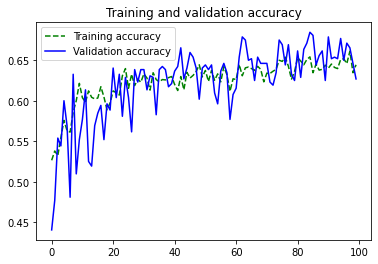

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history7)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'benmal_model7_acc.png'))

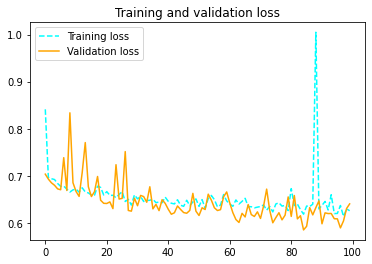

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history7)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model7_loss.png'))

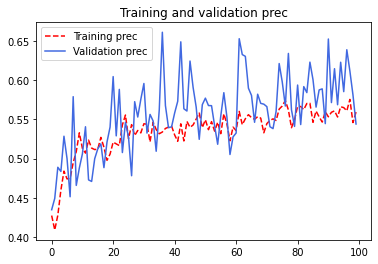

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_prec(history7)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model7_prec.png'))

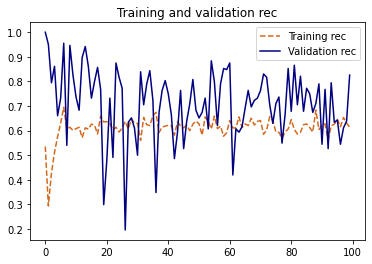

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_rec(history7)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model7_rec.png'))

In [ ]:
print_opt_results(history7)

Epoch [end]: 100
Epoch [opt]: 85
Valid accuracy [end]: 0.6269
Valid accuracy [opt]: 0.6846
Valid loss [end]: 0.6403
Valid loss [opt]: 0.5850
Valid precision [end]: 0.6403
Valid precision [opt]: 0.6230
Valid recall [end]: 0.6269
Valid recall [opt]: 0.6786


In [ ]:
test_model(model7)

16/16 [==============================] - 0s 8ms/step - loss: 0.7328 - acc: 0.5000 - prec: 0.3891 - rec: 0.7748 - auc: 0.6709

---------------------------------
Accuracy: 50.00 %
Loss: 0.73 %
Precision: 38.91 %
Recall: 77.48 %
AUC: 0.67
---------------------------------



### Model 7.2
Model 3.2 with batch size 64

In [ ]:
BATCH_SIZE=64

In [ ]:
model72 = models.Sequential()
model72.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model72.add(layers.MaxPooling2D((2, 2)))
model72.add(layers.Conv2D(64, (3, 3), activation='relu'))
model72.add(layers.MaxPooling2D((2, 2)))
model72.add(layers.Conv2D(128, (3, 3), activation='relu'))
model72.add(layers.MaxPooling2D((2, 2)))
model72.add(layers.Conv2D(128, (3, 3), activation='relu'))
model72.add(layers.Flatten())
model72.add(layers.Dense(64, activation="relu"))
model72.add(layers.Dropout(0.2))
model72.add(layers.Dense(1, activation='sigmoid'))

model72.compile(loss="binary_crossentropy",
              optimizer='rmsprop',
              metrics=METRICS)

model72.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 17, 17, 128)     

In [ ]:
history72 = model72.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    class_weight=dict(enumerate(class_weights)))

Epoch 1/100
33/33 [==============================] - 6s 130ms/step - loss: 0.8565 - acc: 0.4816 - prec: 0.4094 - rec: 0.6542 - auc: 0.5217 - val_loss: 0.6867 - val_acc: 0.5508 - val_prec: 0.4867 - val_rec: 0.6577 - val_auc: 0.6214
Epoch 2/100
33/33 [==============================] - 4s 124ms/step - loss: 0.7010 - acc: 0.4957 - prec: 0.4247 - rec: 0.6659 - auc: 0.5345 - val_loss: 0.6954 - val_acc: 0.4395 - val_prec: 0.4354 - val_rec: 0.9865 - val_auc: 0.6194
Epoch 3/100
33/33 [==============================] - 4s 127ms/step - loss: 0.6994 - acc: 0.5072 - prec: 0.4288 - rec: 0.6172 - auc: 0.5355 - val_loss: 0.6928 - val_acc: 0.4668 - val_prec: 0.4465 - val_rec: 0.9595 - val_auc: 0.6361
Epoch 4/100
33/33 [==============================] - 4s 128ms/step - loss: 0.6885 - acc: 0.4937 - prec: 0.4332 - rec: 0.7671 - auc: 0.5480 - val_loss: 0.6875 - val_acc: 0.5000 - val_prec: 0.4624 - val_rec: 0.9414 - val_auc: 0.6480
Epoch 5/100
33/33 [==============================] - 4s 128ms/step - loss: 0

In [ ]:
model72.save(os.path.join(MODEL_PATH,'benmal_model72.h5'))

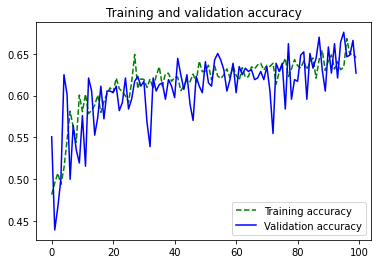

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history72)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'benmal_model72_acc.png'))

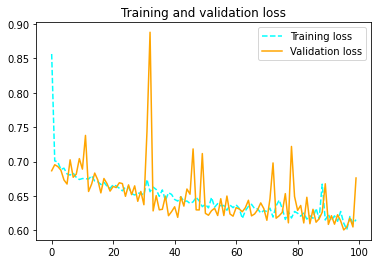

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history72)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model72_loss.png'))

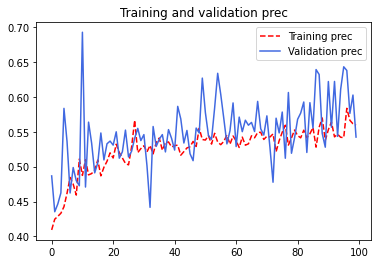

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_prec(history72)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model72_prec.png'))

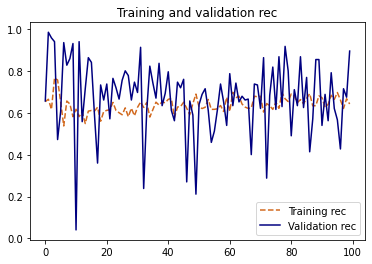

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_rec(history72)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model72_rec.png'))

In [ ]:
print_opt_results(history72)

Epoch [end]: 100
Epoch [opt]: 96
Valid accuracy [end]: 0.6270
Valid accuracy [opt]: 0.6758
Valid loss [end]: 0.6761
Valid loss [opt]: 0.6006
Valid precision [end]: 0.6761
Valid precision [opt]: 0.6429
Valid recall [end]: 0.6270
Valid recall [opt]: 0.5676


In [ ]:
test_model(model72)

5/5 [==============================] - 0s 26ms/step - loss: 0.7766 - acc: 0.4969 - prec: 0.3950 - rec: 0.8468 - auc: 0.6857

---------------------------------
Accuracy: 49.69 %
Loss: 0.78 %
Precision: 39.50 %
Recall: 84.68 %
AUC: 0.69
---------------------------------



## Model 8
Model 3.2 with batch size 32 and 150 epochs

In [ ]:
BATCH_SIZE=32
EPOCHS=150

In [ ]:
model8 = models.Sequential()
model8.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model8.add(layers.MaxPooling2D((2, 2)))
model8.add(layers.Conv2D(64, (3, 3), activation='relu'))
model8.add(layers.MaxPooling2D((2, 2)))
model8.add(layers.Conv2D(128, (3, 3), activation='relu'))
model8.add(layers.MaxPooling2D((2, 2)))
model8.add(layers.Conv2D(128, (3, 3), activation='relu'))
model8.add(layers.Flatten())
model8.add(layers.Dense(64, activation="relu"))
model8.add(layers.Dropout(0.2))
model8.add(layers.Dense(1, activation='sigmoid'))

model8.compile(loss="binary_crossentropy",
              optimizer='rmsprop',
              metrics=METRICS)

model8.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 17, 17, 128)     

In [ ]:
history8 = model8.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    class_weight=dict(enumerate(class_weights)))

Epoch 1/150
66/66 [==============================] - 6s 72ms/step - loss: 0.7925 - acc: 0.4798 - prec: 0.3986 - rec: 0.5965 - auc: 0.5158 - val_loss: 0.6897 - val_acc: 0.5664 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00 - val_auc: 0.6064
Epoch 2/150
66/66 [==============================] - 5s 69ms/step - loss: 0.6939 - acc: 0.5313 - prec: 0.4226 - rec: 0.4098 - auc: 0.5108 - val_loss: 0.6917 - val_acc: 0.5664 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00 - val_auc: 0.5032
Epoch 3/150
66/66 [==============================] - 4s 68ms/step - loss: 0.6955 - acc: 0.5123 - prec: 0.4327 - rec: 0.6279 - auc: 0.5241 - val_loss: 0.6783 - val_acc: 0.5859 - val_prec: 0.5197 - val_rec: 0.5946 - val_auc: 0.6310
Epoch 4/150
66/66 [==============================] - 5s 68ms/step - loss: 0.6876 - acc: 0.5674 - prec: 0.4721 - rec: 0.5215 - auc: 0.5616 - val_loss: 0.6780 - val_acc: 0.5703 - val_prec: 0.5031 - val_rec: 0.7207 - val_auc: 0.6406
Epoch 5/150
66/66 [==============================] - 5s 68ms/ste

In [ ]:
model8.save(os.path.join(MODEL_PATH,'benmal_model8.h5'))

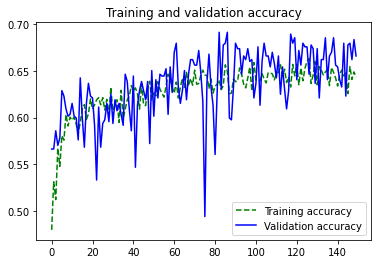

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history8)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'benmal_model8_acc.png'))

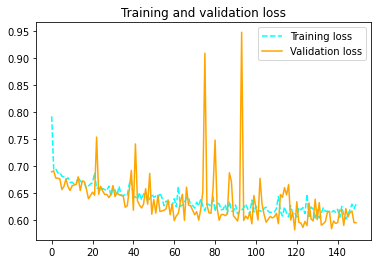

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history8)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model8_loss.png'))

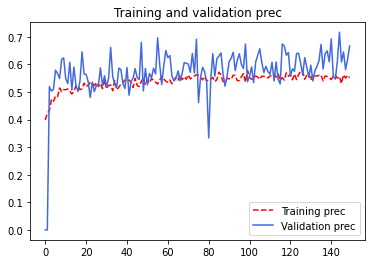

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_prec(history8)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model8_prec.png'))

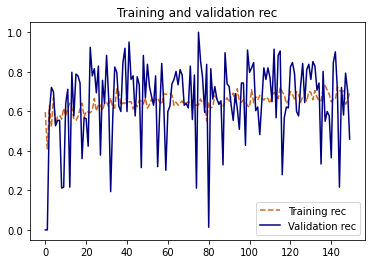

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_rec(history8)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_model8_rec.png'))

In [ ]:
print_opt_results(history8)

Epoch [end]: 150
Epoch [opt]: 83
Valid accuracy [end]: 0.6660
Valid accuracy [opt]: 0.6914
Valid loss [end]: 0.5955
Valid loss [opt]: 0.6001
Valid precision [end]: 0.5955
Valid precision [opt]: 0.6391
Valid recall [end]: 0.6660
Valid recall [opt]: 0.6622


In [ ]:
test_model(model8)

10/10 [==============================] - 0s 14ms/step - loss: 0.6204 - acc: 0.6594 - prec: 0.5100 - rec: 0.4595 - auc: 0.6491

---------------------------------
Accuracy: 65.94 %
Loss: 0.62 %
Precision: 51.00 %
Recall: 45.95 %
AUC: 0.65
---------------------------------



## Model 9
Model 3.2 with different learning rate :

1.   lr=0.00001
2.   lr=0.0001
3.   lr=0.01



In [ ]:
BATCH_SIZE=32
EPOCHS=100

### Model 9.1

In [ ]:
model91 = models.Sequential()
model91.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model91.add(layers.MaxPooling2D((2, 2)))
model91.add(layers.Conv2D(64, (3, 3), activation='relu'))
model91.add(layers.MaxPooling2D((2, 2)))
model91.add(layers.Conv2D(128, (3, 3), activation='relu'))
model91.add(layers.MaxPooling2D((2, 2)))
model91.add(layers.Conv2D(128, (3, 3), activation='relu'))
model91.add(layers.Flatten())
model91.add(layers.Dense(64, activation="relu"))
model91.add(layers.Dropout(0.2))
model91.add(layers.Dense(1, activation='sigmoid'))

model91.compile(optimizer=optimizers.RMSprop(learning_rate=0.00001), 
              loss="binary_crossentropy", 
              metrics=METRICS)

model91.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [ ]:
history91 = model91.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    class_weight=dict(enumerate(class_weights)))

Epoch 1/100
66/66 [==============================] - 18s 102ms/step - loss: 0.6912 - acc: 0.4375 - prec: 0.4131 - rec: 0.8879 - auc: 0.5466 - val_loss: 0.6921 - val_acc: 0.5566 - val_prec: 0.2857 - val_rec: 0.0089 - val_auc: 0.4338
Epoch 2/100
66/66 [==============================] - 7s 100ms/step - loss: 0.6913 - acc: 0.5057 - prec: 0.4248 - rec: 0.5977 - auc: 0.5202 - val_loss: 0.6952 - val_acc: 0.4395 - val_prec: 0.4384 - val_rec: 1.0000 - val_auc: 0.6457
Epoch 3/100
66/66 [==============================] - 6s 95ms/step - loss: 0.6914 - acc: 0.4241 - prec: 0.4065 - rec: 0.8908 - auc: 0.5313 - val_loss: 0.6938 - val_acc: 0.4414 - val_prec: 0.4392 - val_rec: 1.0000 - val_auc: 0.6607
Epoch 4/100
66/66 [==============================] - 6s 95ms/step - loss: 0.6917 - acc: 0.4421 - prec: 0.4155 - rec: 0.8877 - auc: 0.5309 - val_loss: 0.6952 - val_acc: 0.4395 - val_prec: 0.4384 - val_rec: 1.0000 - val_auc: 0.6947
Epoch 5/100
66/66 [==============================] - 7s 104ms/step - loss: 0.

In [ ]:
model91.save(os.path.join(MODEL_PATH,'calcmasses_model91.h5'))

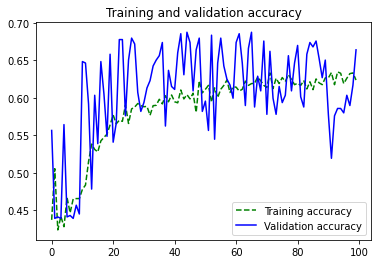

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history91)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model91_acc.png'))

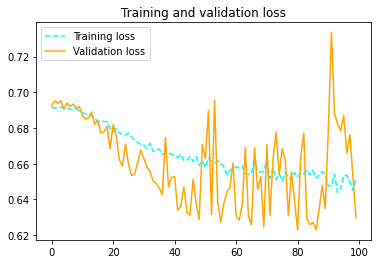

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history91)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model91_loss.png'))

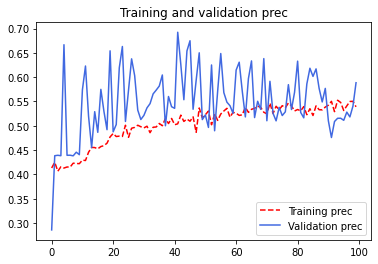

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_prec(history91)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model91_prec.png'))

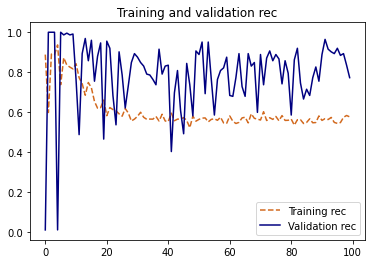

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_rec(history91)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model91_rec.png'))

In [ ]:
print_opt_results(history91)

Epoch [end]: 100
Epoch [opt]: 45
Valid accuracy [end]: 0.6641
Valid accuracy [opt]: 0.6875
Valid loss [end]: 0.6298
Valid loss [opt]: 0.6331
Valid precision [end]: 0.6298
Valid precision [opt]: 0.6538
Valid recall [end]: 0.6641
Valid recall [opt]: 0.6071


In [ ]:
test_model(model91)

10/10 [==============================] - 0s 24ms/step - loss: 0.6838 - acc: 0.5719 - prec: 0.4222 - rec: 0.6972 - auc: 0.6600

---------------------------------
Accuracy: 57.19 %
Loss: 0.68 %
Precision: 42.22 %
Recall: 69.72 %
AUC: 0.66
---------------------------------



### Model 9.2

In [ ]:
model92 = models.Sequential()
model92.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model92.add(layers.MaxPooling2D((2, 2)))
model92.add(layers.Conv2D(64, (3, 3), activation='relu'))
model92.add(layers.MaxPooling2D((2, 2)))
model92.add(layers.Conv2D(128, (3, 3), activation='relu'))
model92.add(layers.MaxPooling2D((2, 2)))
model92.add(layers.Conv2D(128, (3, 3), activation='relu'))
model92.add(layers.Flatten())
model92.add(layers.Dense(64, activation="relu"))
model92.add(layers.Dropout(0.2))
model92.add(layers.Dense(1, activation='sigmoid'))

model92.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001), 
              loss="binary_crossentropy", 
              metrics=METRICS)

model92.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 17, 17, 128)     

In [ ]:
history92 = model92.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    class_weight=dict(enumerate(class_weights)))

Epoch 1/100
66/66 [==============================] - 9s 106ms/step - loss: 0.6917 - acc: 0.5169 - prec: 0.4217 - rec: 0.5766 - auc: 0.5362 - val_loss: 0.6973 - val_acc: 0.4375 - val_prec: 0.4375 - val_rec: 1.0000 - val_auc: 0.6749
Epoch 2/100
66/66 [==============================] - 6s 96ms/step - loss: 0.6917 - acc: 0.4540 - prec: 0.4094 - rec: 0.7683 - auc: 0.5117 - val_loss: 0.6955 - val_acc: 0.4512 - val_prec: 0.4431 - val_rec: 0.9911 - val_auc: 0.6859
Epoch 3/100
66/66 [==============================] - 6s 96ms/step - loss: 0.6873 - acc: 0.5133 - prec: 0.4368 - rec: 0.6620 - auc: 0.5628 - val_loss: 0.6925 - val_acc: 0.4609 - val_prec: 0.4465 - val_rec: 0.9688 - val_auc: 0.6951
Epoch 4/100
66/66 [==============================] - 6s 94ms/step - loss: 0.6874 - acc: 0.5190 - prec: 0.4371 - rec: 0.6125 - auc: 0.5533 - val_loss: 0.6796 - val_acc: 0.5742 - val_prec: 0.5074 - val_rec: 0.9152 - val_auc: 0.6988
Epoch 5/100
66/66 [==============================] - 6s 94ms/step - loss: 0.683

In [ ]:
model92.save(os.path.join(MODEL_PATH,'calcmasses_model92.h5'))

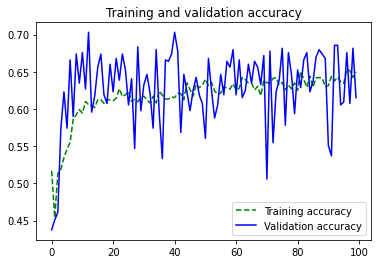

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history92)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model92_acc.png'))

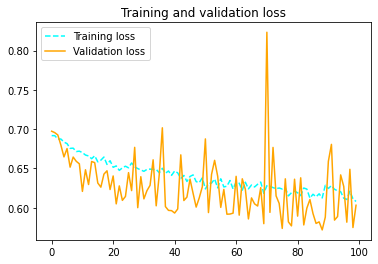

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history92)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model92_loss.png'))

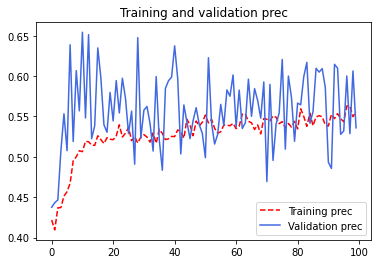

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_prec(history92)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model92_prec.png'))

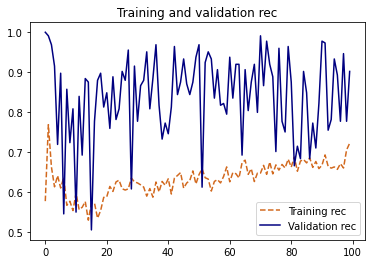

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_rec(history92)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model92_rec.png'))

In [ ]:
print_opt_results(history92)

Epoch [end]: 100
Epoch [opt]: 13
Valid accuracy [end]: 0.6152
Valid accuracy [opt]: 0.7031
Valid loss [end]: 0.6031
Valid loss [opt]: 0.6295
Valid precision [end]: 0.6031
Valid precision [opt]: 0.6513
Valid recall [end]: 0.6152
Valid recall [opt]: 0.6920


In [ ]:
test_model(model92)

10/10 [==============================] - 0s 23ms/step - loss: 0.6925 - acc: 0.4875 - prec: 0.3868 - rec: 0.8624 - auc: 0.6865

---------------------------------
Accuracy: 48.75 %
Loss: 0.69 %
Precision: 38.68 %
Recall: 86.24 %
AUC: 0.69
---------------------------------



### Model 9.3

In [ ]:
model93 = models.Sequential()
model93.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model93.add(layers.MaxPooling2D((2, 2)))
model93.add(layers.Conv2D(64, (3, 3), activation='relu'))
model93.add(layers.MaxPooling2D((2, 2)))
model93.add(layers.Conv2D(128, (3, 3), activation='relu'))
model93.add(layers.MaxPooling2D((2, 2)))
model93.add(layers.Conv2D(128, (3, 3), activation='relu'))
model93.add(layers.Flatten())
model93.add(layers.Dense(64, activation="relu"))
model93.add(layers.Dropout(0.2))
model93.add(layers.Dense(1, activation='sigmoid'))

model93.compile(optimizer=optimizers.RMSprop(learning_rate=0.01), 
              loss="binary_crossentropy", 
              metrics=METRICS)

model93.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 17, 17, 128)     

In [ ]:
history93 = model93.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    class_weight=dict(enumerate(class_weights)))

Epoch 1/100
66/66 [==============================] - 9s 104ms/step - loss: 48.9924 - acc: 0.4625 - prec: 0.4035 - rec: 0.7216 - auc: 0.5071 - val_loss: 0.6942 - val_acc: 0.4375 - val_prec: 0.4375 - val_rec: 1.0000 - val_auc: 0.5000
Epoch 2/100
66/66 [==============================] - 6s 95ms/step - loss: 0.6918 - acc: 0.5204 - prec: 0.4082 - rec: 0.3935 - auc: 0.4969 - val_loss: 0.6916 - val_acc: 0.5625 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00 - val_auc: 0.5000
Epoch 3/100
66/66 [==============================] - 6s 95ms/step - loss: 0.6918 - acc: 0.5403 - prec: 0.4089 - rec: 0.2875 - auc: 0.4927 - val_loss: 0.6918 - val_acc: 0.5625 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00 - val_auc: 0.5000
Epoch 4/100
66/66 [==============================] - 6s 92ms/step - loss: 0.6922 - acc: 0.5806 - prec: 0.3854 - rec: 0.0429 - auc: 0.4797 - val_loss: 0.6922 - val_acc: 0.5625 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00 - val_auc: 0.5000
Epoch 5/100
66/66 [==============================] - 6

In [ ]:
model93.save(os.path.join(MODEL_PATH,'calcmasses_model93.h5'))

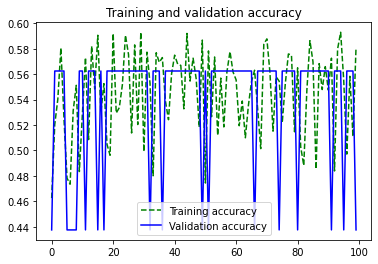

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history93)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model93_acc.png'))

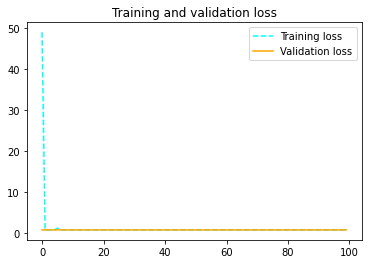

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history93)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model93_loss.png'))

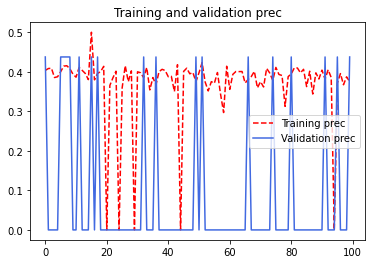

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_prec(history93)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model93_prec.png'))

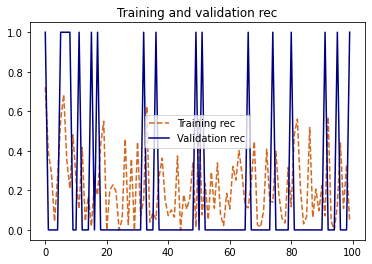

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_rec(history93)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model93_rec.png'))

In [ ]:
print_opt_results(history93)

Epoch [end]: 100
Epoch [opt]: 2
Valid accuracy [end]: 0.4375
Valid accuracy [opt]: 0.5625
Valid loss [end]: 0.6939
Valid loss [opt]: 0.6916
Valid precision [end]: 0.6939
Valid precision [opt]: 0.0000
Valid recall [end]: 0.4375
Valid recall [opt]: 0.0000


In [ ]:
test_model(model93)

10/10 [==============================] - 0s 22ms/step - loss: 0.6950 - acc: 0.3406 - prec: 0.3406 - rec: 1.0000 - auc: 0.5000

---------------------------------
Accuracy: 34.06 %
Loss: 0.70 %
Precision: 34.06 %
Recall: 100.00 %
AUC: 0.50
---------------------------------



## Model 10
Model 3.2 with Adam and different learning rate :

1.   lr=0.00001
2.   lr=0.0001
3.   lr=0.001 (dafault)



In [ ]:
BATCH_SIZE=32
EPOCHS=100

### Model 10.1

In [ ]:
model101 = models.Sequential()
model101.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model101.add(layers.MaxPooling2D((2, 2)))
model101.add(layers.Conv2D(64, (3, 3), activation='relu'))
model101.add(layers.MaxPooling2D((2, 2)))
model101.add(layers.Conv2D(128, (3, 3), activation='relu'))
model101.add(layers.MaxPooling2D((2, 2)))
model101.add(layers.Conv2D(128, (3, 3), activation='relu'))
model101.add(layers.Flatten())
model101.add(layers.Dense(64, activation="relu"))
model101.add(layers.Dropout(0.2))
model101.add(layers.Dense(1, activation='sigmoid'))

model101.compile(optimizer=optimizers.Adam(learning_rate=0.00001), 
              loss="binary_crossentropy", 
              metrics=METRICS)

model91.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [ ]:
history101 = model101.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    class_weight=dict(enumerate(class_weights)))

Epoch 1/100
66/66 [==============================] - 8s 99ms/step - loss: 0.6919 - acc: 0.5037 - prec: 0.3876 - rec: 0.4175 - auc: 0.4848 - val_loss: 0.6950 - val_acc: 0.4375 - val_prec: 0.4375 - val_rec: 1.0000 - val_auc: 0.6686
Epoch 2/100
66/66 [==============================] - 6s 92ms/step - loss: 0.6912 - acc: 0.4094 - prec: 0.4087 - rec: 0.9988 - auc: 0.5651 - val_loss: 0.6959 - val_acc: 0.4375 - val_prec: 0.4375 - val_rec: 1.0000 - val_auc: 0.6665
Epoch 3/100
66/66 [==============================] - 6s 90ms/step - loss: 0.6916 - acc: 0.4108 - prec: 0.4090 - rec: 0.9977 - auc: 0.5280 - val_loss: 0.6943 - val_acc: 0.4375 - val_prec: 0.4375 - val_rec: 1.0000 - val_auc: 0.6876
Epoch 4/100
66/66 [==============================] - 6s 91ms/step - loss: 0.6915 - acc: 0.4103 - prec: 0.4080 - rec: 0.9872 - auc: 0.5346 - val_loss: 0.6947 - val_acc: 0.4375 - val_prec: 0.4375 - val_rec: 1.0000 - val_auc: 0.6839
Epoch 5/100
66/66 [==============================] - 6s 91ms/step - loss: 0.6915

In [ ]:
model101.save(os.path.join(MODEL_PATH,'calcmasses_model101.h5'))

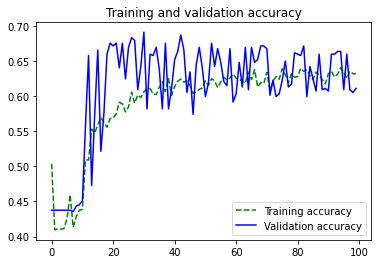

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history101)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model101_acc.png'))

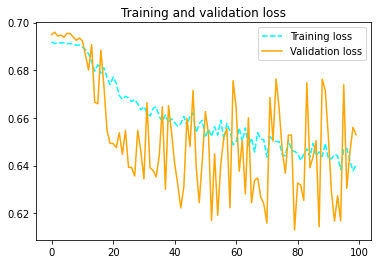

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history101)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model101_loss.png'))

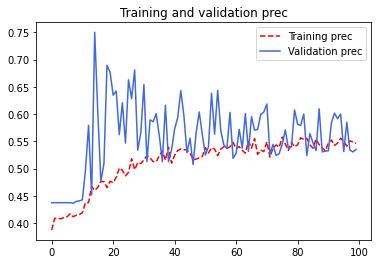

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_prec(history101)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model101_prec.png'))

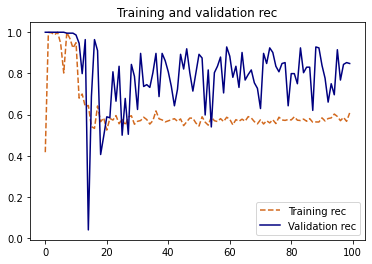

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_rec(history101)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model101_rec.png'))

In [ ]:
print_opt_results(history101)

Epoch [end]: 100
Epoch [opt]: 31
Valid accuracy [end]: 0.6113
Valid accuracy [opt]: 0.6914
Valid loss [end]: 0.6529
Valid loss [opt]: 0.6344
Valid precision [end]: 0.6529
Valid precision [opt]: 0.6542
Valid recall [end]: 0.6113
Valid recall [opt]: 0.6250


In [ ]:
test_model(model101)

10/10 [==============================] - 0s 23ms/step - loss: 0.7370 - acc: 0.4969 - prec: 0.3870 - rec: 0.8165 - auc: 0.6647

---------------------------------
Accuracy: 49.69 %
Loss: 0.74 %
Precision: 38.70 %
Recall: 81.65 %
AUC: 0.66
---------------------------------



### Model 10.2

In [ ]:
model102 = models.Sequential()
model102.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model102.add(layers.MaxPooling2D((2, 2)))
model102.add(layers.Conv2D(64, (3, 3), activation='relu'))
model102.add(layers.MaxPooling2D((2, 2)))
model102.add(layers.Conv2D(128, (3, 3), activation='relu'))
model102.add(layers.MaxPooling2D((2, 2)))
model102.add(layers.Conv2D(128, (3, 3), activation='relu'))
model102.add(layers.Flatten())
model102.add(layers.Dense(64, activation="relu"))
model102.add(layers.Dropout(0.2))
model102.add(layers.Dense(1, activation='sigmoid'))

model102.compile(optimizer=optimizers.Adam(learning_rate=0.0001), 
              loss="binary_crossentropy", 
              metrics=METRICS)

model102.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 17, 17, 128)     

In [ ]:
history102 = model102.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    class_weight=dict(enumerate(class_weights)))

Epoch 1/100
66/66 [==============================] - 8s 99ms/step - loss: 0.6924 - acc: 0.4592 - prec: 0.4093 - rec: 0.7979 - auc: 0.5405 - val_loss: 0.6964 - val_acc: 0.4375 - val_prec: 0.4375 - val_rec: 1.0000 - val_auc: 0.6668
Epoch 2/100
66/66 [==============================] - 6s 89ms/step - loss: 0.6917 - acc: 0.4217 - prec: 0.4044 - rec: 0.8792 - auc: 0.5244 - val_loss: 0.6931 - val_acc: 0.4492 - val_prec: 0.4413 - val_rec: 0.9732 - val_auc: 0.6065
Epoch 3/100
66/66 [==============================] - 6s 89ms/step - loss: 0.6912 - acc: 0.4829 - prec: 0.4180 - rec: 0.6857 - auc: 0.5265 - val_loss: 0.6948 - val_acc: 0.4414 - val_prec: 0.4390 - val_rec: 0.9955 - val_auc: 0.6700
Epoch 4/100
66/66 [==============================] - 6s 92ms/step - loss: 0.6889 - acc: 0.5066 - prec: 0.4313 - rec: 0.6485 - auc: 0.5558 - val_loss: 0.6767 - val_acc: 0.6289 - val_prec: 0.7576 - val_rec: 0.2232 - val_auc: 0.6807
Epoch 5/100
66/66 [==============================] - 6s 93ms/step - loss: 0.6894

In [ ]:
model102.save(os.path.join(MODEL_PATH,'calcmasses_model92.h5'))

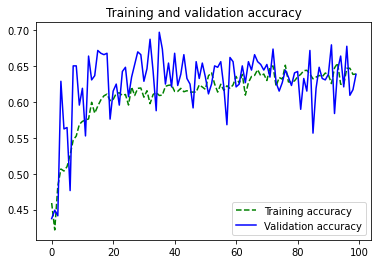

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history102)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model102_acc.png'))

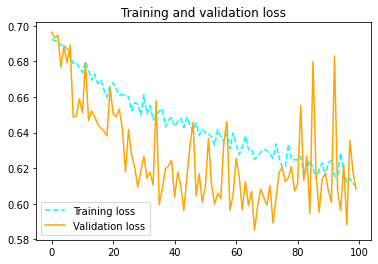

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history102)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model102_loss.png'))

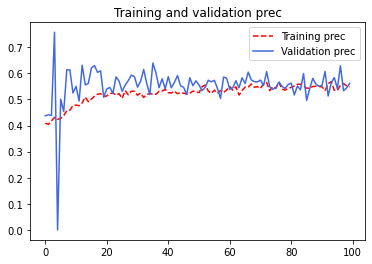

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_prec(history102)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model102_prec.png'))

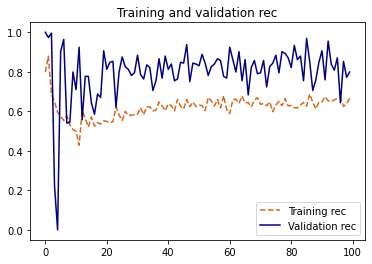

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_rec(history102)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model102_rec.png'))

In [ ]:
print_opt_results(history102)

Epoch [end]: 100
Epoch [opt]: 36
Valid accuracy [end]: 0.6387
Valid accuracy [opt]: 0.6973
Valid loss [end]: 0.6081
Valid loss [opt]: 0.5994
Valid precision [end]: 0.6081
Valid precision [opt]: 0.6397
Valid recall [end]: 0.6387
Valid recall [opt]: 0.7054


In [ ]:
test_model(model102)

10/10 [==============================] - 0s 22ms/step - loss: 0.6707 - acc: 0.5562 - prec: 0.4195 - rec: 0.7890 - auc: 0.6725

---------------------------------
Accuracy: 55.62 %
Loss: 0.67 %
Precision: 41.95 %
Recall: 78.90 %
AUC: 0.67
---------------------------------



### Model 10.3

In [ ]:
model103 = models.Sequential()
model103.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model103.add(layers.MaxPooling2D((2, 2)))
model103.add(layers.Conv2D(64, (3, 3), activation='relu'))
model103.add(layers.MaxPooling2D((2, 2)))
model103.add(layers.Conv2D(128, (3, 3), activation='relu'))
model103.add(layers.MaxPooling2D((2, 2)))
model103.add(layers.Conv2D(128, (3, 3), activation='relu'))
model103.add(layers.Flatten())
model103.add(layers.Dense(64, activation="relu"))
model103.add(layers.Dropout(0.2))
model103.add(layers.Dense(1, activation='sigmoid'))

model103.compile(optimizer=optimizers.Adam(), 
              loss="binary_crossentropy", 
              metrics=METRICS)

model103.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 17, 17, 128)     

In [ ]:
history103 = model103.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    class_weight=dict(enumerate(class_weights)))

Epoch 1/100
66/66 [==============================] - 8s 102ms/step - loss: 0.6971 - acc: 0.5395 - prec: 0.4241 - rec: 0.4127 - auc: 0.5347 - val_loss: 0.6847 - val_acc: 0.5625 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00 - val_auc: 0.6657
Epoch 2/100
66/66 [==============================] - 6s 90ms/step - loss: 0.6856 - acc: 0.5659 - prec: 0.4646 - rec: 0.4284 - auc: 0.5702 - val_loss: 0.6860 - val_acc: 0.5312 - val_prec: 0.4817 - val_rec: 0.9420 - val_auc: 0.6855
Epoch 3/100
66/66 [==============================] - 6s 90ms/step - loss: 0.6823 - acc: 0.5607 - prec: 0.4683 - rec: 0.5763 - auc: 0.5821 - val_loss: 0.6801 - val_acc: 0.5527 - val_prec: 0.4941 - val_rec: 0.9286 - val_auc: 0.7108
Epoch 4/100
66/66 [==============================] - 6s 91ms/step - loss: 0.6788 - acc: 0.5517 - prec: 0.4643 - rec: 0.6764 - auc: 0.6030 - val_loss: 0.6690 - val_acc: 0.6602 - val_prec: 0.5906 - val_rec: 0.7277 - val_auc: 0.7266
Epoch 5/100
66/66 [==============================] - 6s 91ms/step - los

In [ ]:
model103.save(os.path.join(MODEL_PATH,'calcmasses_model103.h5'))

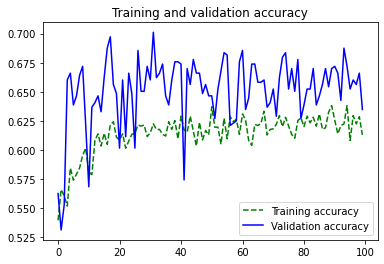

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history103)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model103_acc.png'))

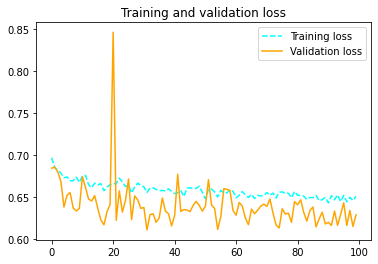

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history103)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model103_loss.png'))

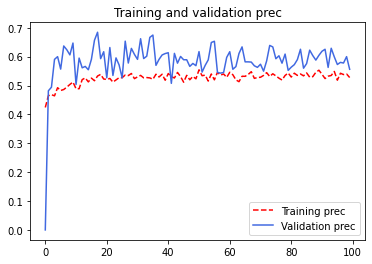

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_prec(history103)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model103_prec.png'))

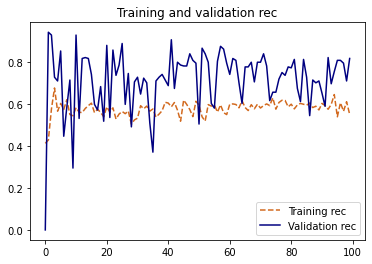

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_rec(history103)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'calcmasses_model103_rec.png'))

In [ ]:
print_opt_results(history103)

Epoch [end]: 100
Epoch [opt]: 32
Valid accuracy [end]: 0.6348
Valid accuracy [opt]: 0.7012
Valid loss [end]: 0.6293
Valid loss [opt]: 0.6113
Valid precision [end]: 0.6293
Valid precision [opt]: 0.6621
Valid recall [end]: 0.6348
Valid recall [opt]: 0.6473


In [ ]:
test_model(model103)

10/10 [==============================] - 0s 22ms/step - loss: 0.6992 - acc: 0.5625 - prec: 0.4265 - rec: 0.8257 - auc: 0.6808

---------------------------------
Accuracy: 56.25 %
Loss: 0.70 %
Precision: 42.65 %
Recall: 82.57 %
AUC: 0.68
---------------------------------



## Best Model
Model 3.2

In [ ]:
BATCH_SIZE=32
EPOCHS=100

In [ ]:
model_best = models.Sequential()
model_best.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model_best.add(layers.MaxPooling2D((2, 2)))
model_best.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_best.add(layers.MaxPooling2D((2, 2)))
model_best.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_best.add(layers.MaxPooling2D((2, 2)))
model_best.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_best.add(layers.Flatten())
model_best.add(layers.Dense(64, activation="relu"))
model_best.add(layers.Dropout(0.2))
model_best.add(layers.Dense(1, activation='sigmoid'))

model_best.compile(loss="binary_crossentropy",
              optimizer='rmsprop',
              metrics=METRICS)

model_best.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 17, 17, 128)     

In [ ]:
history_best = model_best.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    class_weight=dict(enumerate(class_weights)))

Epoch 1/100
66/66 [==============================] - 9s 102ms/step - loss: 0.7483 - acc: 0.5284 - prec: 0.4178 - rec: 0.4649 - auc: 0.5241 - val_loss: 0.6934 - val_acc: 0.4453 - val_prec: 0.4398 - val_rec: 0.9777 - val_auc: 0.6448
Epoch 2/100
66/66 [==============================] - 6s 97ms/step - loss: 0.6946 - acc: 0.5213 - prec: 0.4212 - rec: 0.4519 - auc: 0.5023 - val_loss: 0.6925 - val_acc: 0.4688 - val_prec: 0.4500 - val_rec: 0.9643 - val_auc: 0.6772
Epoch 3/100
66/66 [==============================] - 7s 107ms/step - loss: 0.6927 - acc: 0.5005 - prec: 0.4279 - rec: 0.6620 - auc: 0.5670 - val_loss: 0.7222 - val_acc: 0.4492 - val_prec: 0.4415 - val_rec: 0.9777 - val_auc: 0.6878
Epoch 4/100
66/66 [==============================] - 15s 228ms/step - loss: 0.6885 - acc: 0.5498 - prec: 0.4645 - rec: 0.6270 - auc: 0.5644 - val_loss: 0.7054 - val_acc: 0.5625 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00 - val_auc: 0.6676
Epoch 5/100
66/66 [==============================] - 8s 119ms/step -

In [ ]:
model_best.save(os.path.join(MODEL_PATH,'benmal_modelbest.h5'))

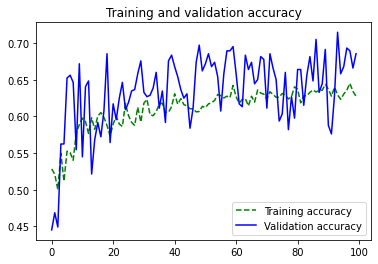

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_a = plot_acc(history_best)
plt_a.show()
plt_a.savefig(os.path.join(PLOTS_PATH, 'benmal_modelbest_acc.png'))

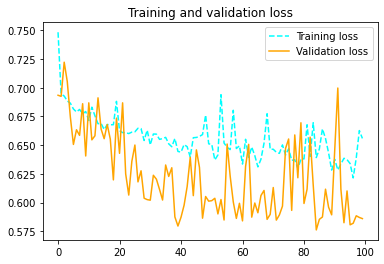

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history_best)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_modelbest_loss.png'))

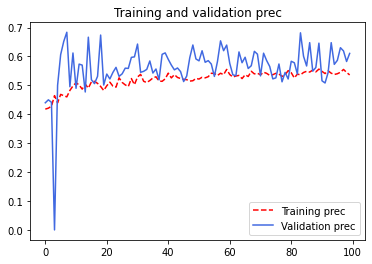

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_prec(history_best)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_modelbest_prec.png'))

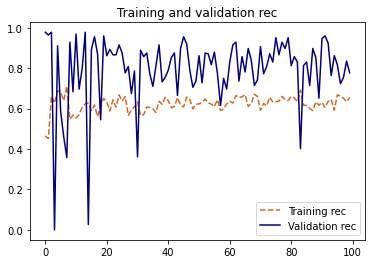

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_rec(history_best)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_modelbest_rec.png'))

In [ ]:
print_opt_results(history_best)

Epoch [end]: 100
Epoch [opt]: 94
Valid accuracy [end]: 0.6855
Valid accuracy [opt]: 0.7148
Valid loss [end]: 0.5860
Valid loss [opt]: 0.5824
Valid precision [end]: 0.5860
Valid precision [opt]: 0.6477
Valid recall [end]: 0.6855
Valid recall [opt]: 0.7634


In [ ]:
test_model(model_best)

10/10 [==============================] - 0s 24ms/step - loss: 0.6496 - acc: 0.6344 - prec: 0.4756 - rec: 0.7156 - auc: 0.7051

---------------------------------
Accuracy: 63.44 %
Loss: 0.65 %
Precision: 47.56 %
Recall: 71.56 %
AUC: 0.71
---------------------------------



## Print AUC Best Model

###Model 4

In [ ]:
test_model(model_best)

10/10 [==============================] - 0s 33ms/step - loss: 0.6496 - acc: 0.6344 - prec: 0.4756 - rec: 0.7156 - auc: 0.7051

---------------------------------
Accuracy: 63.44 %
Loss: 0.65 %
Precision: 47.56 %
Recall: 71.56 %
AUC: 0.71
---------------------------------



In [ ]:
model_best = load_model(os.path.join(MODEL_PATH,'benmal_model4.h5'))

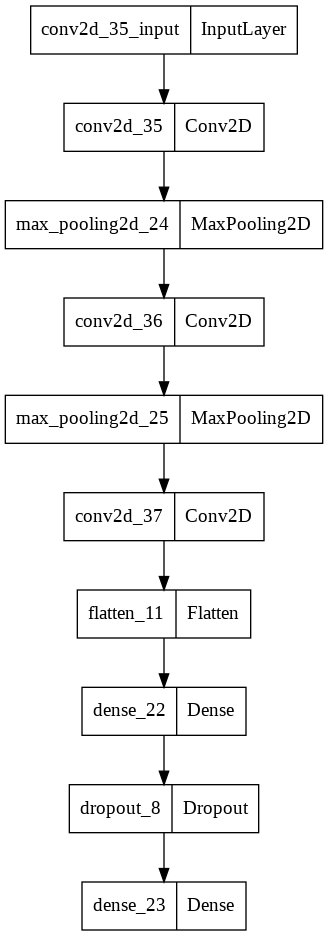

In [ ]:
plot_model(model_best)

(336,)
(336, 150, 150, 1)
(336, 1)
(336, 1)
Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.73      0.66      0.69       219
         1.0       0.46      0.54      0.49       117

    accuracy                           0.62       336
   macro avg       0.59      0.60      0.59       336
weighted avg       0.63      0.62      0.62       336



Text(0.5, -6.819805153394636, 'Predicted label')

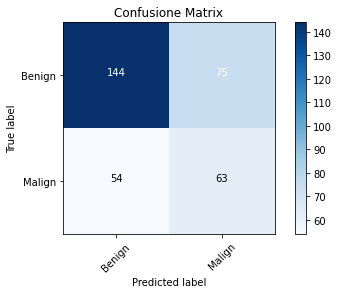

In [ ]:
classes = ["Benign", "Malign"]
Y_pred = model_best.predict(test_datagen.flow(test_images,
                                            test_labels,
                                            batch_size=BATCH_SIZE+2,
                                            shuffle=False),
                          steps=len(test_images) // BATCH_SIZE)

y_pred = np.where(Y_pred < 0.5, 0, 1)


print(test_labels.shape)
print(test_images.shape)
print(Y_pred.shape)
print(y_pred.shape)

print('Confusion Matrix')
cm = confusion_matrix(test_labels, y_pred)

#print(cm)
#print('Classification Report')
print(classification_report(test_labels, y_pred))

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusione Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

#print(cm)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')


In [ ]:
fpr,tpr,th = roc_curve(test_labels, Y_pred)

roc_auc = roc_auc_score(test_labels, Y_pred)

roc auc:  0.6930492135971588


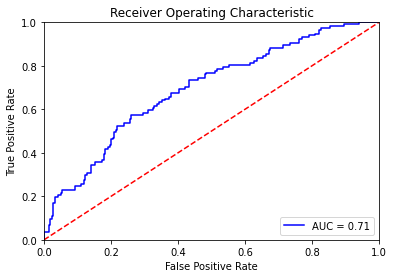

In [ ]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

###Model 3.2

In [ ]:
model_best = load_model(os.path.join(MODEL_PATH,'benmal_model32.h5'))

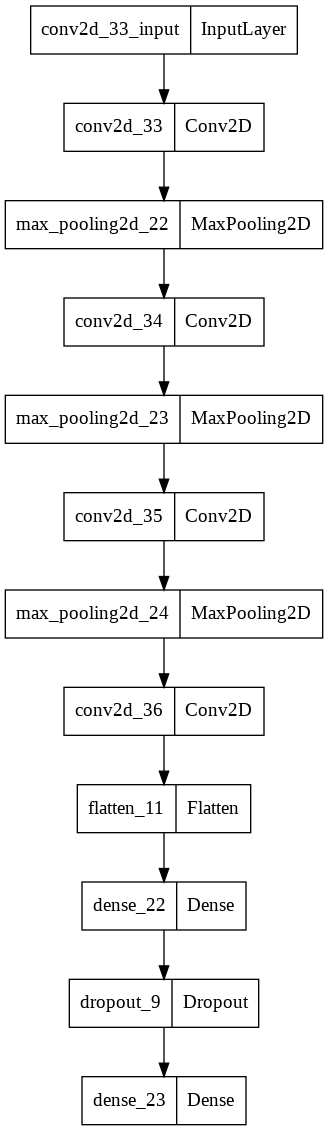

In [ ]:
plot_model(model_best)

In [ ]:
test_loss, test_accuracy, test_precision, test_recall, test_auc = model_best.evaluate(test_datagen.flow(test_images,
                                          test_labels,
                                          batch_size=BATCH_SIZE,
                                          shuffle=False),
                                          steps=len(test_images) // BATCH_SIZE)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
print("Loss:", "%0.2f" % (test_loss), "%")
print("Precision:", "%0.2f" % (test_precision*100), "%")
print("Recall:", "%0.2f" % (test_recall*100), "%")
print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")

10/10 [==============================] - 4s 346ms/step - loss: 0.6700 - acc: 0.6187 - prec: 0.4667 - rec: 0.6937 - auc: 0.6836

---------------------------------
Accuracy: 61.87 %
Loss: 0.67 %
Precision: 46.67 %
Recall: 69.37 %
AUC: 0.68
---------------------------------



(336,)
(336, 150, 150, 1)
(336, 1)
(336, 1)
Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.79      0.58      0.67       219
         1.0       0.47      0.70      0.57       117

    accuracy                           0.62       336
   macro avg       0.63      0.64      0.62       336
weighted avg       0.68      0.62      0.63       336



Text(0.5, -6.819805153394636, 'Predicted label')

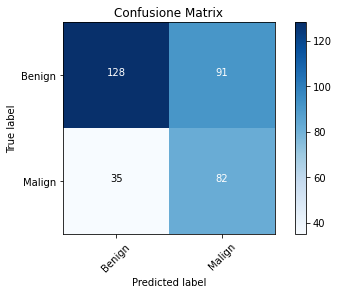

In [ ]:
classes = ["Benign", "Malign"]
Y_pred = model_best.predict(test_datagen.flow(test_images,
                                            test_labels,
                                            batch_size=BATCH_SIZE+2,
                                            shuffle=False),
                          steps=len(test_images) // BATCH_SIZE)

y_pred = np.where(Y_pred < 0.5, 0, 1)


print(test_labels.shape)
print(test_images.shape)
print(Y_pred.shape)
print(y_pred.shape)

print('Confusion Matrix')
cm = confusion_matrix(test_labels, y_pred)

#print(cm)
#print('Classification Report')
print(classification_report(test_labels, y_pred))

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusione Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

#print(cm)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')


In [ ]:
fpr,tpr,th = roc_curve(test_labels, Y_pred)

roc_auc = roc_auc_score(test_labels, Y_pred)

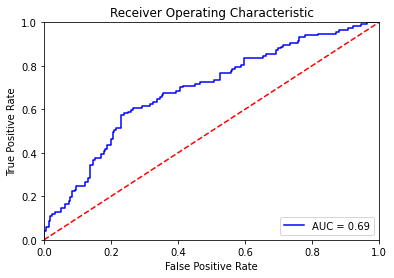

In [ ]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

###Model 3.2

In [ ]:
model_best = load_model(os.path.join(MODEL_PATH,'benmal_modelbest.h5'))

10/10 [==============================] - 0s 33ms/step - loss: 0.6496 - acc: 0.6344 - prec: 0.4756 - rec: 0.7156 - auc: 0.7051

---------------------------------
Accuracy: 63.44 %
Loss: 0.65 %
Precision: 47.56 %
Recall: 71.56 %
AUC: 0.71
---------------------------------



In [ ]:
plot_model(model_best)

In [ ]:
test_loss, test_accuracy, test_precision, test_recall, test_auc = model_best.evaluate(test_datagen.flow(test_images,
                                          test_labels,
                                          batch_size=BATCH_SIZE,
                                          shuffle=False),
                                          steps=len(test_images) // BATCH_SIZE)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
print("Loss:", "%0.2f" % (test_loss), "%")
print("Precision:", "%0.2f" % (test_precision*100), "%")
print("Recall:", "%0.2f" % (test_recall*100), "%")
print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")

10/10 [==============================] - 0s 33ms/step - loss: 0.6496 - acc: 0.6344 - prec: 0.4756 - rec: 0.7156 - auc: 0.7051

---------------------------------
Accuracy: 63.44 %
Loss: 0.65 %
Precision: 47.56 %
Recall: 71.56 %
AUC: 0.71
---------------------------------



(336,)
(336, 150, 150, 1)
(336, 1)
(336, 1)
Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.78      0.59      0.67       219
         1.0       0.47      0.69      0.56       117

    accuracy                           0.62       336
   macro avg       0.63      0.64      0.62       336
weighted avg       0.67      0.62      0.63       336



Text(0.5, -6.819805153394636, 'Predicted label')

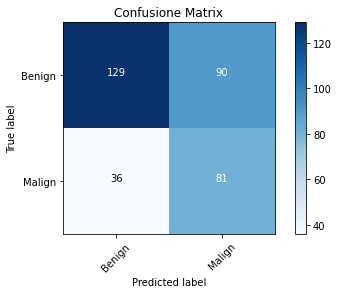

In [ ]:
classes = ["Benign", "Malign"]
Y_pred = model_best.predict(test_datagen.flow(test_images,
                                            test_labels,
                                            batch_size=BATCH_SIZE+2,
                                            shuffle=False),
                          steps=len(test_images) // BATCH_SIZE)

y_pred = np.where(Y_pred < 0.5, 0, 1)


print(test_labels.shape)
print(test_images.shape)
print(Y_pred.shape)
print(y_pred.shape)

print('Confusion Matrix')
cm = confusion_matrix(test_labels, y_pred)

#print(cm)
#print('Classification Report')
print(classification_report(test_labels, y_pred))

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusione Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

#print(cm)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')


In [ ]:
fpr,tpr,th = roc_curve(test_labels, Y_pred)

roc_auc = roc_auc_score(test_labels, Y_pred)

roc auc:  0.6930492135971588


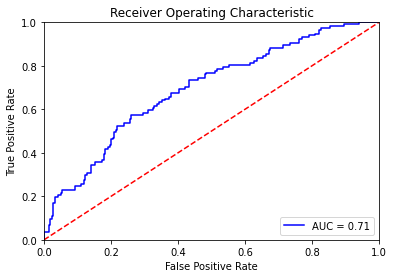

In [ ]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()